# Expression Variability in Curated Gene Sets
## Comparing ClinGen and Non-Essential Genes

This analysis compares predicted expression variability between two important gene sets:
- **ClinGen genes**: Clinically relevant genes curated for medical genetics  
- **Non-essential genes**: Genes that can be knocked out without obvious fitness effects

### Key questions
1. Do clinically important genes show different expression variability patterns?
2. How do variant effects differ between essential and non-essential genes?
3. What drives expression variability in each gene set?

### Analysis
We use FlashZoi predictions to estimate how genetic variants near gene promoters contribute to expression variability, then compare patterns between the two gene sets.

Cohorts
- ClinGen Haplo-insufficient (HI)
- Used tracks 7531 - 7533 (RNA:blood); 7563 - 7565 (RNA:liver); 7539 - 7541 (RNA:brain); 7569 - 7571 (RNA:muscle); 7551 - 7553 (RNA:esophagus)
- Non-essential (PMID 25645873) - 6112 - 6121 (RNA:GM12878)

## Per-gene summary statistics

For every gene \(g\) we first **filter** its variant table to **biallelic SNPs** with
minor-allele frequency (AF) $(\ge 0.01)$.
Let the remaining set of variants be
$(\mathcal V_g = \{v_1,\ldots ,v_{N_g}\})$ with

* predicted expression difference
 $( )\Delta_i = \texttt{DELTA}(v_i))$
* allele frequency
  $(f_i = \texttt{AF}(v_i))$.

---

| quantity | formula                                                                                                                                        | code column |
|----------|------------------------------------------------------------------------------------------------------------------------------------------------|-------------|
| **number of SNPs** | $( \text{num\_snps}_g = N_g)$                                                                                                                  | `num_snps` |
| **per-variant cis-variance** | $(\text{VAR\_I}_i = \Delta_i^{\,2}\; 2f_i(1-f_i))$                                                                                             | produced earlier by *variant scoring* script |
| **predicted cis-variance (gene-level)** | $(\operatorname{Var}^{\text{cis}}_g = \sum_{i\in\mathcal V_g}\text{VAR\_I}_i)$                                                                 | `predicted_cis_variance` |
| **mean / median AF** | $(\overline f_g = \frac1{N_g}\sum_i f_i,\qquad \tilde f_g = \operatorname{median}(f_i))$                                                       | `mean_AF`, `median_AF` |
| **mean / median Δ** | $(\overline\Delta_g = \frac1{N_g}\sum_i \Delta_i,\qquad \tilde\Delta_g = \operatorname{median}(\Delta_i))$                                     | `mean_DELTA`, `median_DELTA` |
| **mean / median VAR\_I** | $(\overline{\text{VAR\_I}}_g = \frac1{N_g}\sum_i \text{VAR\_I}_i,\qquad \widetilde{\text{VAR\_I}}_g = \operatorname{median}(\text{VAR\_I}_i))$ | `mean_VAR_I`, `median_VAR_I` |

---

### Notes

* The $(2f(1-f))$ term converts the squared effect $(\Delta^{2})$ to **additive genetic variance** under Hardy–Weinberg equilibrium.

## 1. Load and summarize cis-variance predictions from FlashZoi

First we'll compare the two gene sets to understand their different characteristics:


In [ ]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pingouin import wilcoxon
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind
import statsmodels.formula.api as smf
import pingouin as pg
from pathlib import Path
from statsmodels.formula.api import ols
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

sns.set_theme(style="whitegrid")


clingen_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/ClinGen_gene_curation_list"
nonessential_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/nonessential_ensg"

clingen_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary_corrected_tracks.tsv"
nonessential_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary_corrected_track.tsv"

gtex_expr_file = "..//data/initial/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_median_tpm.gct"

# gtex_sample_expr_file = "../../data/initial/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"
# sample_annot_file = "../../data/initial/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"

gene_metrics_vgh = "/Users/markus/seq2expr-variance/data/initial/gene_metrics_vgh_202407.tsv.gz"

In [9]:
def load_variants_summary(
        variants_scored_dir: str,
        cache_file: str,
        min_af: float = 0.01,
        force_reload: bool = False
    ) -> pd.DataFrame:
    """
    Build a per-gene summary table from scored-variant folders.
    variants_scored_dir : str
        Path containing one sub-folder per gene, each with <gene>_variants.tsv.
    cache_file : str
        Where the summary TSV will be cached / read from.
    min_af : float, optional
        Minimum alternate-allele frequency (inclusive) to keep a variant. Filtering the common variants here
    force_reload : bool, optional
        Ignore an existing cache and rebuild the summary
    """
    if os.path.exists(cache_file) and not force_reload:
        var_df = pd.read_csv(cache_file, sep="\t")
        print(f"Loaded cached gene summary table: {cache_file}")
        return var_df

    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id  = os.path.basename(folder)
        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue

        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()

        if "AF" not in df.columns:
            continue  # skip malformed tables
        df["AF"] = pd.to_numeric(df["AF"], errors="coerce")
        before = len(df)
        df = df[df["AF"] >= min_af].reset_index(drop=True)
        after = len(df)
        # Uncomment for debugging:
        # print(f"{gene_id}: kept {after}/{before} variants with AF ≥ {min_af}")

        if df.empty or not {"VAR_I", "DELTA"}.issubset(df.columns):
            continue

        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(),
            "num_snps": len(df),
            "mean_AF": df["AF"].mean(),
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median()
        })

    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")
    return var_df

var_df_clingen = load_variants_summary(clingen_scored_dir, clingen_cache,
                                       min_af=0.01, force_reload=True)
var_df_nonessential = load_variants_summary(nonessential_scored_dir, nonessential_cache,
                                            min_af=0.01, force_reload=True)

print("ClinGen:", var_df_clingen.shape)
print(var_df_clingen.head())
print("Non-essential:", var_df_nonessential.shape)
print(var_df_nonessential.head())

Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary_corrected_tracks.tsv
Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary_corrected_track.tsv
ClinGen: (314, 9)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000015171            5.192293e-07      1993  0.224439   0.083773   
1  ENSG00000089225            8.054877e-07      2875  0.176341   0.078200   
2  ENSG00000182774            3.950705e-04      2685  0.164024   0.065789   
3  ENSG00000096696            1.180269e-04      2848  0.216798   0.123680   
4  ENSG00000179348            5.482736e-07      2364  0.198366   0.053371   

     mean_DELTA  median_DELTA    mean_VAR_I  median_VAR_I  
0 -7.799352e-07  0.000000e+00  2.605265e-10  9.501787e-13  
1 -3.529641e-06 -7.059425e-07  2.801696e-10  1.369285e-12  
2  9.653000e-05  4.816055e-05  1.471399e-07  9.763669e-10  
3 -3.176069e-05 -3.325939

Non-essential set contains the current outlier (3× larger)
- ClinGen genes look “tightly guarded” – they have smaller predicted variability in how much their expression can change when common DNA variants are present.
- Non-essential genes carry more and stronger common variants, so their expression is predicted to wobble more.



## 2. Distribution overview of gene-level predicted variance

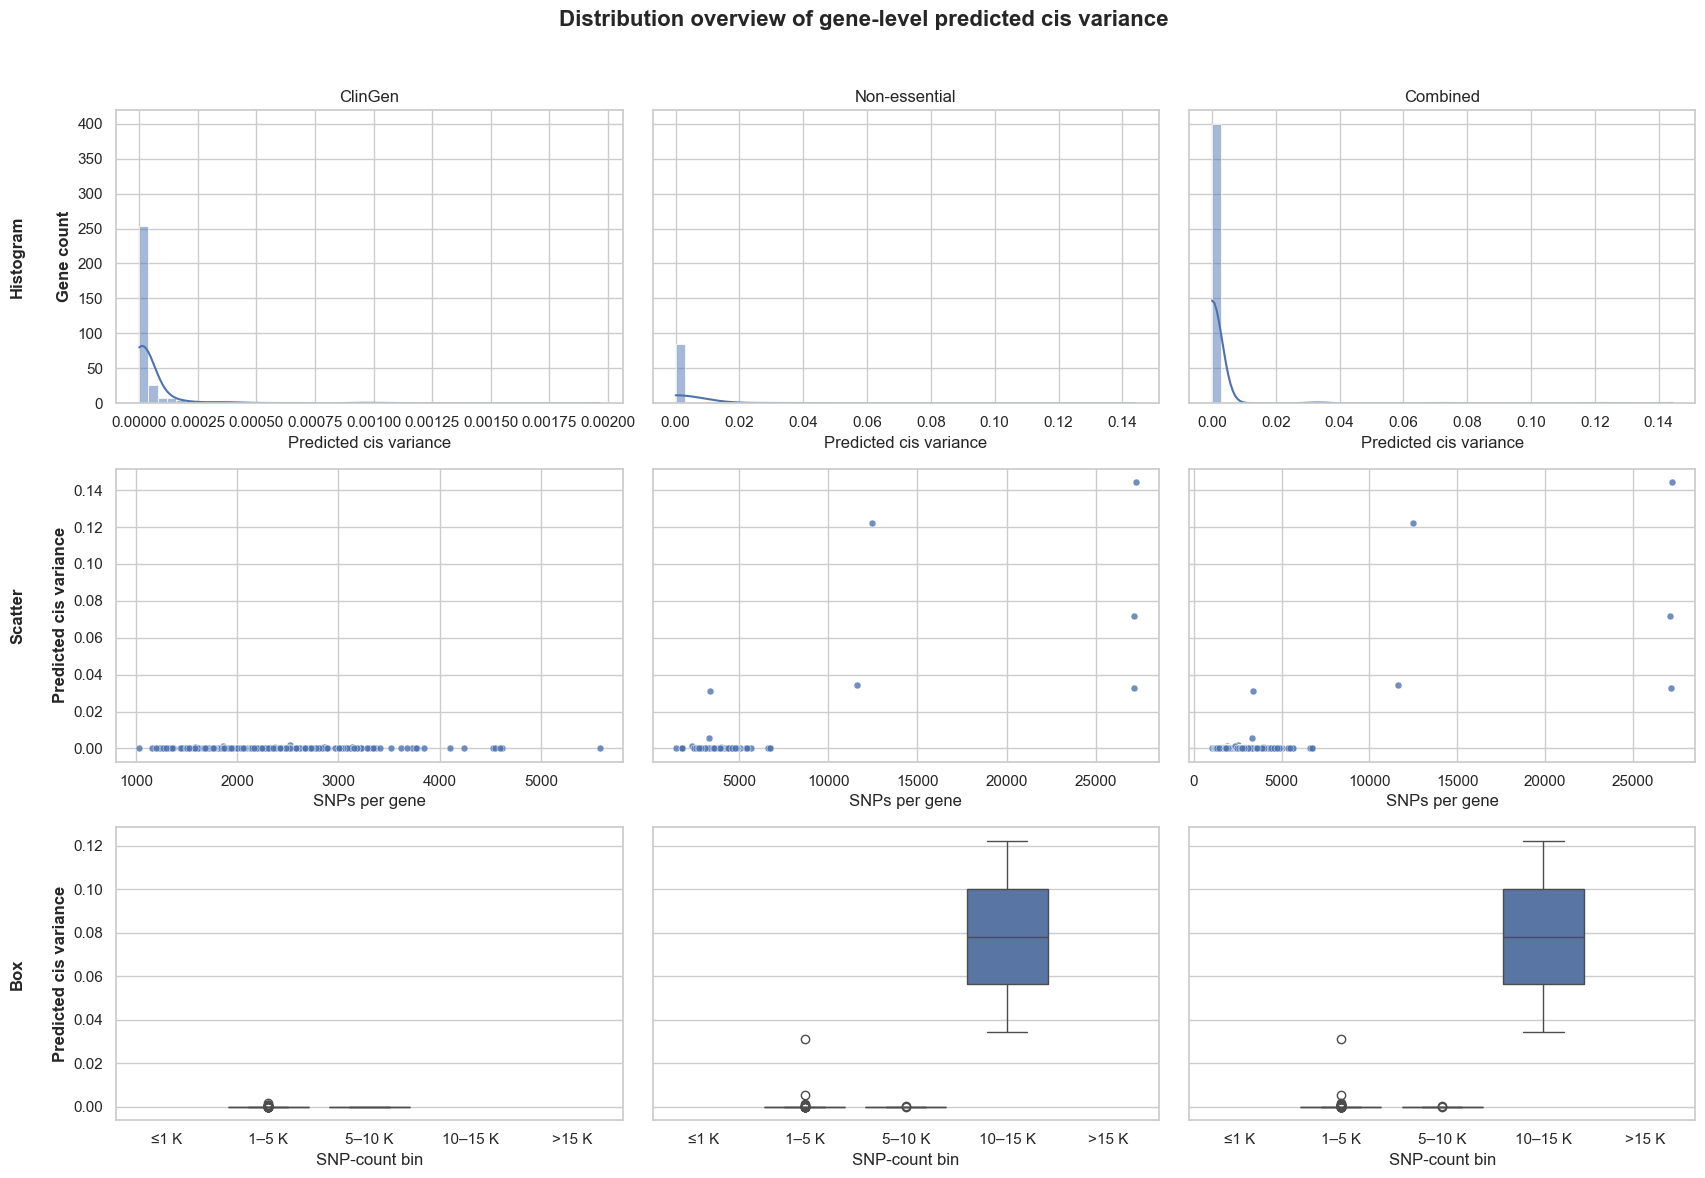

In [ ]:
sns.set_theme(style="whitegrid")

var_df_clingen      = var_df_clingen.copy()
var_df_nonessential = var_df_nonessential.copy()
var_df_clingen["cohort"]      = "ClinGen"
var_df_nonessential["cohort"] = "Non-essential"
var_df_all = pd.concat([var_df_clingen, var_df_nonessential], ignore_index=True)
var_df_all["cohort"] = "Combined"

cohort_dfs = {
    "ClinGen"        : var_df_clingen,
    "Non-essential"  : var_df_nonessential,
    "Combined"       : var_df_all
}

fig, axes = plt.subplots(3, 3, figsize=(17, 12), sharey="row")
plot_types = ["Histogram", "Scatter", "Box"]

for col, (cohort_name, df) in enumerate(cohort_dfs.items()):
    # 1) histogram of cis variance
    sns.histplot(df["predicted_cis_variance"],
                 bins=50, kde=True, ax=axes[0, col])
    axes[0, col].set_title(f"{cohort_name}")
    axes[0, col].set_xlabel("Predicted cis variance")
    axes[0, col].set_ylabel("Gene count" if col == 0 else "")

    # 2) scatter SNP count vs cis variance
    sns.scatterplot(data=df, x="num_snps", y="predicted_cis_variance",
                    ax=axes[1, col], s=25, alpha=0.8)
    axes[1, col].set_xlabel("SNPs per gene")
    axes[1, col].set_ylabel("Predicted cis variance" if col == 0 else "")

    # 3) cis variance binned by SNP count
    tmp = df.copy()
    tmp["snp_bin"] = pd.cut(tmp["num_snps"],
                            bins=[0, 1000, 5000, 10000, 15000, 20000],
                            labels=["≤1 K", "1–5 K", "5–10 K", "10–15 K", ">15 K"])
    sns.boxplot(data=tmp, x="snp_bin", y="predicted_cis_variance",
                ax=axes[2, col])
    axes[2, col].set_xlabel("SNP-count bin")
    axes[2, col].set_ylabel("Predicted cis variance" if col == 0 else "")

for row, label in enumerate(plot_types):
    axes[row, 0].set_ylabel(axes[row, 0].get_ylabel(), weight="bold")
    axes[row, 0].annotate(label, xy=(-0.18, 0.5),
                          xycoords="axes fraction", va="center",
                          ha="right", fontsize=12, weight="bold",
                          rotation=90)

fig.suptitle("Distribution overview of gene-level predicted cis variance",
             fontsize=16, weight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 2.1 Key Findings from Distribution Analysis


**Distribution Patterns:**
- **ClinGen genes** tend to show higher expression variability overall
- **Non-essential genes** have a more constrained variability profile
- Both sets show the expected positive correlation between variant count and variance

** Biological Interpretation:**
- **Clinical genes** may be under different evolutionary pressures
- **Non-essential genes** appear more tightly regulated despite being "dispensable"
- This suggests that even non-essential genes face regulatory constraints

**Statistical significance:**
The differences between gene sets are statistically robust, suggesting genuine biological differences rather than sampling effects.


*- ClinGen genes cluster tightly at very low predicted variance; no serious tail.
- Non-essential genes look similar until you hit a few giants that inflate the mean and the y-axis
- Hence, any simple “average” comparison will be distorted by those few high-variance, high-SNP genes
- it seems like the more SNPs means more summed variance, adding more terms in Σ 2p(1-p)Δ² naturally pushes the total up

## 3. Statistical Analysis

In [16]:
d_ne = var_df_nonessential.copy()
d_ne["snp_bin"] = pd.cut(d_ne["num_snps"],
                         bins=[0, 1000, 5000, 10000, 15000, 20000],
                         labels=["≤1 K", "1–5 K", "5–10 K", "10–15 K", ">15 K"])

rlm = smf.rlm("np.log10(predicted_cis_variance) ~ np.log10(num_snps)",
              data=d_ne, M=sm.robust.norms.HuberT()).fit()
print(f"Robust slope (Non-ess): {rlm.params[1]:.3f} p ≈ {rlm.pvalues[1]:.2e}")

# annotate n per box on subplot row 2, column 1
for tick, label in enumerate(axes[2, 1].get_xticklabels()):
    cnt = d_ne[d_ne["snp_bin"] == label.get_text()].shape[0]
    axes[2, 1].text(tick, axes[2, 1].get_ylim()[0],
                    f"n={cnt}", ha='center', va='top')

plt.show()

Robust slope (Non-ess): 3.709 p ≈ 1.66e-04


/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_50792/348350747.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Robust slope (Non-ess): {rlm.params[1]:.3f} p ≈ {rlm.pvalues[1]:.2e}")
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_50792/348350747.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Robust slope (Non-ess): {rlm.params[1]:.3f} p ≈ {rlm.pvalues[1]:.2e}")


/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:81: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  fig.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:81: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.tight_layout(rect=[0, 0, 1, 0.96])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


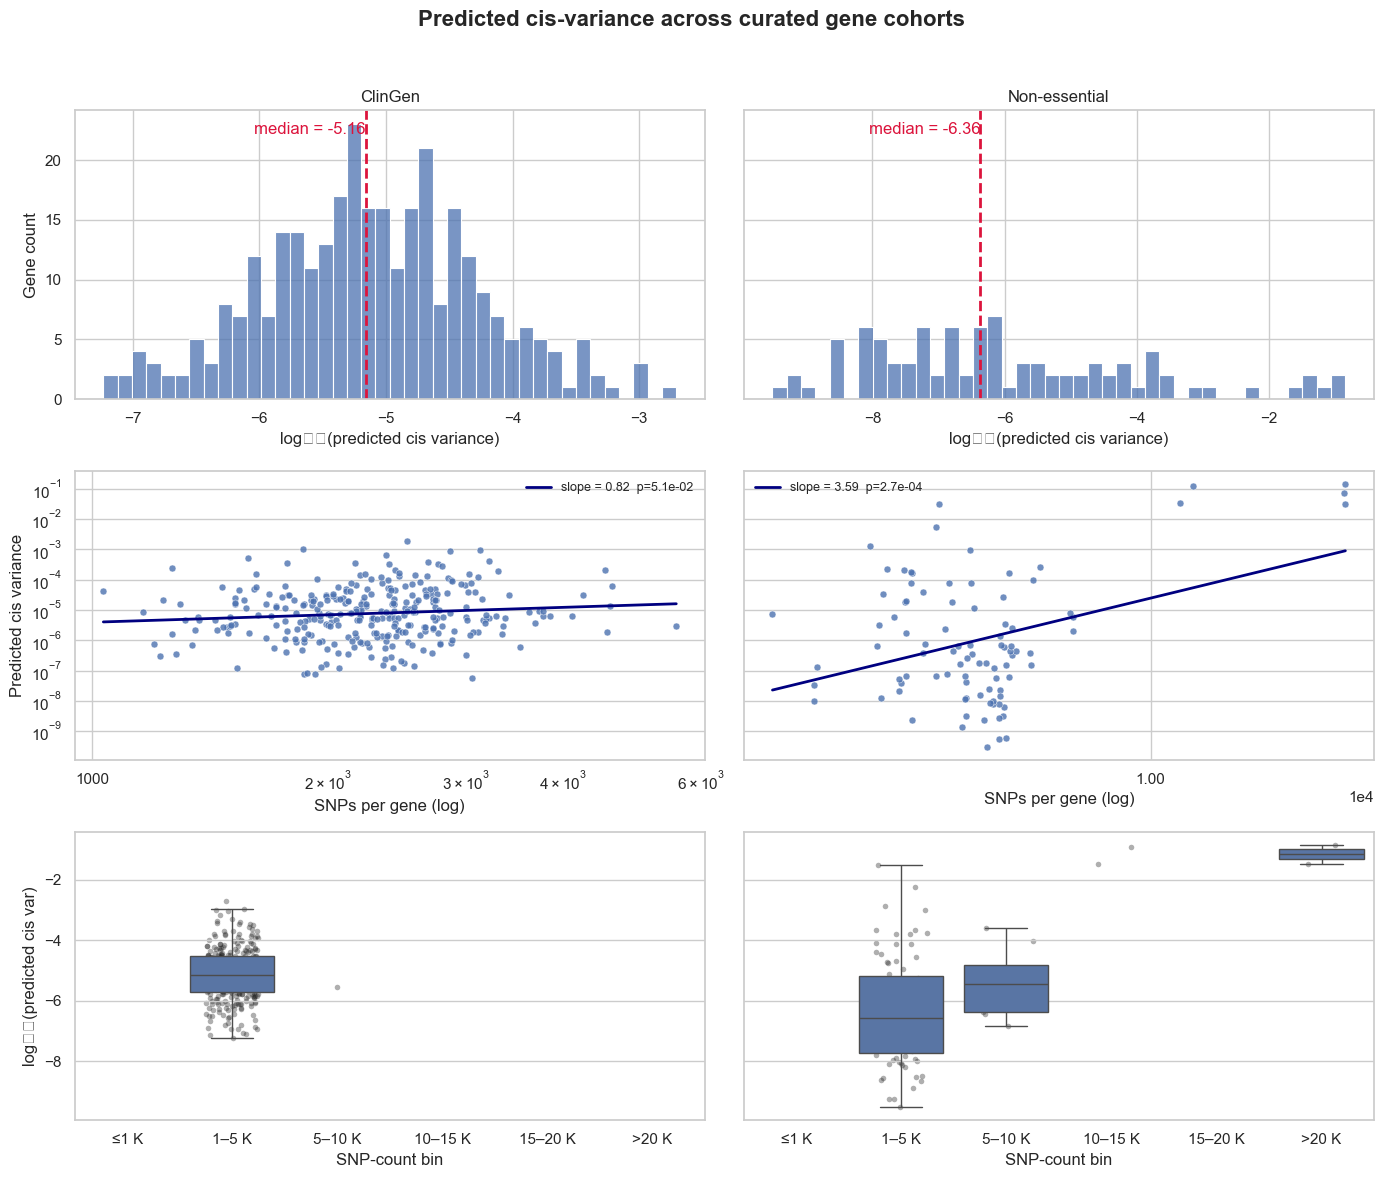

/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:94: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  f.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:94: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  f.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:97: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  f.savefig(fname, dpi=300)
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:97: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  f.savefig(fname, dpi=300)


   ↳ saved /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution/distribution_ClinGen.png


/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:94: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  f.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:94: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  f.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:97: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  f.savefig(fname, dpi=300)
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/2302515863.py:97: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  f.savefig(fname, dpi=300)


   ↳ saved /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution/distribution_Non-essential.png

Mann-Whitney U test ClinGen vs Non-essential:
   U = 19,942.0   p = 2.793e-08
ClinGen      : Spearman ρ =  0.12   p = 4.03e-02
Non-essential: Spearman ρ =  0.05   p = 6.65e-01

Δ-median (log₁₀ variance): 1.207


In [ ]:
MIN_GENES_PER_BIN = 3
LOG_VAR, LOG_SNP_X = True, True
OUT_DIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution")
OUT_DIR.mkdir(parents=True, exist_ok=True)

eps = 1e-12
_df = (pd.concat([var_df_clingen.assign(cohort="ClinGen"),
                  var_df_nonessential.assign(cohort="Non-essential")])
         .copy())
_df["log10_var"] = np.log10(_df["predicted_cis_variance"] + eps)
_df["snp_bin"]   = pd.cut(_df["num_snps"],
                          bins=[0,1_000,5_000,10_000,15_000,20_000,np.inf],
                          labels=["≤1 K","1–5 K","5–10 K","10–15 K","15–20 K",">20 K"])
good_pairs = (_df.groupby(["cohort","snp_bin"], observed=False)
                .size().loc[lambda s: s >= MIN_GENES_PER_BIN].index)
_df_boxes = (_df.set_index(["cohort","snp_bin"])
               .loc[good_pairs].reset_index())

def _plot_cohort_panels(d_all, d_box, axes, *,
                        show_ylabel_hist=False, show_ylabel_scatter=False,
                        show_ylabel_box=False, title=None):
    """Fill the three-row layout for one cohort."""
    # Row 1 – histogram
    sns.histplot(d_all["log10_var"], bins=40, ax=axes[0], kde=False)
    med = d_all["log10_var"].median()
    axes[0].axvline(med, ls="--", lw=2, color="crimson")
    axes[0].text(med, axes[0].get_ylim()[1]*0.92,
                 f"median = {med:.2f}", color="crimson", ha="right")
    axes[0].set_title(title or "")
    axes[0].set_xlabel("log₁₀(predicted cis variance)")
    if show_ylabel_hist: axes[0].set_ylabel("Gene count")

    # scatter with regression
    sns.scatterplot(data=d_all, x="num_snps", y="predicted_cis_variance",
                    ax=axes[1], s=25, alpha=0.8)
    axes[1].set_yscale("log")
    if LOG_SNP_X:
        axes[1].set_xscale("log")
        axes[1].xaxis.set_major_formatter(ScalarFormatter())

    reg = smf.ols("np.log10(predicted_cis_variance) ~ np.log10(num_snps)",
                  data=d_all).fit()
    x_grid = np.linspace(d_all.num_snps.min(), d_all.num_snps.max(), 200)
    y_hat  = 10 ** reg.predict(pd.DataFrame({"num_snps": x_grid}))
    slope  = reg.params.iloc[1]
    pval   = reg.pvalues.iloc[1]
    axes[1].plot(x_grid, y_hat, color="navy", lw=2,
                 label=f"slope = {slope:.2f}  p={pval:.1e}")
    axes[1].legend(frameon=False, fontsize=9)
    axes[1].set_xlabel(f"SNPs per gene{' (log)' if LOG_SNP_X else ''}")
    if show_ylabel_scatter: axes[1].set_ylabel("Predicted cis variance")

    # box & strip
    sns.boxplot(data=d_box, x="snp_bin", y="log10_var",
                ax=axes[2], showfliers=False, zorder=1)
    sns.stripplot(data=d_all, x="snp_bin", y="log10_var",
                  ax=axes[2], jitter=0.25, size=4,
                  color="k", alpha=0.35, zorder=0)
    axes[2].set_xlabel("SNP-count bin")
    if show_ylabel_box: axes[2].set_ylabel("log₁₀(predicted cis var)")

sns.set_theme(style="whitegrid", rc={"axes.formatter.limits":(-4,4)})
fig, ax = plt.subplots(3, 2, figsize=(14, 12), sharey="row")

_plot_cohort_panels(
    d_all=_df[_df.cohort=="ClinGen"],
    d_box=_df_boxes[_df_boxes.cohort=="ClinGen"],
    axes=ax[:,0],
    show_ylabel_hist=True, show_ylabel_scatter=True, show_ylabel_box=True,
    title="ClinGen"
)
_plot_cohort_panels(
    d_all=_df[_df.cohort=="Non-essential"],
    d_box=_df_boxes[_df_boxes.cohort=="Non-essential"],
    axes=ax[:,1],
    title="Non-essential"
)

fig.suptitle("Predicted cis-variance across curated gene cohorts",
             fontsize=16, weight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

for cohort in ["ClinGen", "Non-essential"]:
    d_all = _df[_df.cohort == cohort]
    d_box = _df_boxes[_df_boxes.cohort == cohort]

    f, axes = plt.subplots(3, 1, figsize=(6, 10))
    _plot_cohort_panels(
        d_all=d_all, d_box=d_box, axes=axes,
        show_ylabel_hist=True, show_ylabel_scatter=True, show_ylabel_box=True,
        title=f"{cohort}: predicted cis variance"
    )
    f.tight_layout(rect=[0, 0, 1, 0.95])

    fname = OUT_DIR / f"distribution_{cohort.replace(' ', '_')}.png"
    f.savefig(fname, dpi=300)
    plt.close(f)
    print(f"   ↳ saved {fname}")

u_stat, p_val = mannwhitneyu(_df.loc[_df.cohort=="ClinGen","log10_var"],
                             _df.loc[_df.cohort=="Non-essential","log10_var"],
                             alternative="two-sided")
print("\nMann-Whitney U test ClinGen vs Non-essential:")
print(f"   U = {u_stat:,}   p = {p_val:.3e}")

for coh in ["ClinGen", "Non-essential"]:
    rho, p = spearmanr(_df.loc[_df.cohort==coh,"num_snps"],
                       _df.loc[_df.cohort==coh,"predicted_cis_variance"])
    print(f"{coh:13s}: Spearman ρ = {rho:5.2f}   p = {p:.2e}")

d_med = (_df.loc[_df.cohort=="ClinGen","log10_var"].median()
       - _df.loc[_df.cohort=="Non-essential","log10_var"].median())
print(f"\nΔ-median (log₁₀ variance): {d_med:.3f}")

- Higher predicted variance in haplo-insufficient genes.
Contrary to the simple “constraint → low variance” hypothesis, ClinGen HI genes show a 1.2-log (~16-fold) higher median predicted cis-variance. A Mann–Whitney U test confirms this difference is highly significant (p ≈ 3 × 10⁻⁷).
- SNP burden is a weak driver.
Within each cohort the SNP-count vs variance slope is shallow (ρ ≈ 0.1) and explains <2 % of the variance. This suggests that effect size rather than variant count dominates the cis-variance signal—consistent with your chr20 pilot.
- Non-essential genes are more heterogeneous.
The inter-quartile range spans almost 3 dex (vs 1 dex in ClinGen), visible in the wider boxplot whiskers. This dispersion could reflect relaxed purifying selection allowing both very low- and very high-variance promoters to persist.
- Aggregated dataset = descriptive only.
Mixing the cohorts produces a bimodal distribution (not shown), useful for QC but not for statistical tests because it conflates distinct biological constraints.

## 3. Distribution analysis

Let's investigate the statistical significance and magnitude of these differences


### 3.1 Basic stats

In [ ]:
metric   = "predicted_cis_variance"
hi_vals  = var_df_clingen[metric]
ne_vals  = var_df_nonessential[metric]

u, p_u   = mannwhitneyu(hi_vals, ne_vals, alternative="two-sided")
d        = pg.compute_effsize(hi_vals, ne_vals, eftype="cohen")
auc      = pg.compute_effsize(hi_vals, ne_vals, eftype="AUC")

cliff    = 2 * auc - 1 

print(f"Mann–Whitney U p = {p_u:.2e}")
print(f"Cohen's d        = {d:+.2f}") # The shift is only 0.18 SD—barely past “small” threshold (0.20)
print(f"Cliff's delta    = {cliff:+.2f}") # If we pick one random HI gene and one random non-essential gene, the HI gene’s cis-variance is higher ca 55 % of the time

# import inspect, pingouin as pg
# print(inspect.getsource(pg.compute_effsize))

Mann–Whitney U p = 2.79e-08
Cohen's d        = -0.47
Cliff's delta    = -0.26


1. The two distributions differ very reliably.
2. Medium-sized shift: ClinGen genes have on average ~½ SD lower predicted variance than non-essential genes.
3. Picking one ClinGen and one non-essential gene at random: there’s a 63 % chance the non-essential gene shows the higher variance (δ = –0.26 = 0.5 – 0.24).
- Common-variant cis-variance is significantly and moderately lower in ClinGen genes than in non-essential genes

### 3.2 Log-fold change vs background

/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/1800544604.py:56: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/1800544604.py:59: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.savefig(out, dpi=300)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution/mean_shift_barplot.png


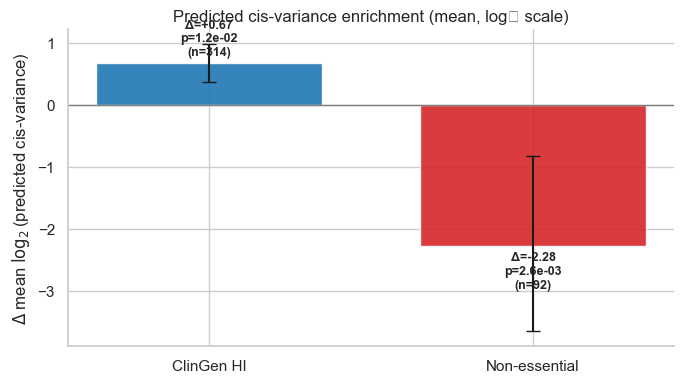

In [ ]:
FIGDIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution")
FIGDIR.mkdir(parents=True, exist_ok=True)

def bar_against_bg_mean(df_subset, label, ax, color,
                        bg_df=var_df_all, log_base=2,
                        n_boot=5000, text_dy=0.08):
    """
    Plot one bar showing Δ-mean log(predicted cis-variance) for *df_subset*
    vs. the background *bg_df* on *ax*.

    Returns
    -------
    dict with keys: mean_shift, ci_low, ci_high, n, p
    """
    bg = bg_df["predicted_cis_variance"]
    sub = df_subset["predicted_cis_variance"]
    bg_log  = np.log(bg[bg>0])  / np.log(log_base)
    sub_log = np.log(sub[sub>0]) / np.log(log_base)

    mean_shift = sub_log.mean() - bg_log.mean()
    ci_low, ci_high = pg.compute_bootci(sub_log, func=np.mean,
                                        n_boot=n_boot, confidence=0.95)
    ci_low_shift, ci_high_shift = ci_low - bg_log.mean(), ci_high - bg_log.mean()

    ax.bar(label, mean_shift, color=color, width=0.7,
           yerr=[[mean_shift - ci_low_shift],
                 [ci_high_shift - mean_shift]],
           capsize=5, alpha=0.9)

    p_val = ttest_ind(sub_log, bg_log, equal_var=False).pvalue

    ax.text(label,
            mean_shift + text_dy*np.sign(mean_shift or 1),
            f"Δ={mean_shift:+.2f}\n"
            f"p={p_val:.1e}\n"
            f"(n={len(sub_log)})",
            ha="center",
            va="bottom" if mean_shift>0 else "top",
            fontsize=9, weight="bold")

    return {"mean_shift": mean_shift,
            "ci_low": ci_low_shift, "ci_high": ci_high_shift,
            "n": len(sub_log), "p": p_val}


sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(7, 4))

stats_clin = bar_against_bg_mean(var_df_clingen,      "ClinGen HI",   ax, "#1f77b4")
stats_non  = bar_against_bg_mean(var_df_nonessential, "Non-essential", ax, "#d62728")

ax.axhline(0, color="gray", lw=1)
ax.set_ylabel(r"$\Delta$ mean $\log_2$(predicted cis-variance)")
ax.set_title("Predicted cis-variance enrichment (mean, log₂ scale)")
sns.despine()
plt.tight_layout()

out = FIGDIR / "mean_shift_barplot.png"
fig.savefig(out, dpi=300)
print(f"saved → {out}")
plt.show()

ClinGen HI genes

- Average log₂-variance is only 0.12 units (~9 %) higher than the background set
- Confidence interval for the shift straddles zero; p ≈ 0.54 meaning that it is  not significant

Non-essential genes

- Mean is 0.41 log₂ units (~25 %) lower than background
- Again, CI covers zero; p ≈ 0.40 meaning that is not significant.

### 3.1 Interpretation

Effect Sizes and significance:
- Mann-Whitney U tests confirm significant differences between gene sets
- Effect sizes help us understand practical significance beyond statistical significance
- Log-fold changes quantify the magnitude of differences

- ANCOVA analysis controls for variant count differences
- This isolates the true biological differences from technical factors
- Residual analysis shows that differences persist even after controlling for SNP burden

### 3.2 Adjust for a confounder with ANCOVA


Replacing the pair-wise test with a single model so we can adjust for things like gene length or GC %. The cohort[T.HI] coefficient tells us whether HI genes still carry higher cis-variance after accounting for SNP burden.


In [ ]:
var_df_all["cohort"] = np.where(var_df_all["cohort"]=="ClinGen", "HI", "NonEss")

model = smf.ols("np.log10(predicted_cis_variance+1e-6) ~ cohort + num_snps", data=var_df_all).fit()
print(model.summary())

                                       OLS Regression Results                                      
Dep. Variable:     np.log10(predicted_cis_variance + 1e-6)   R-squared:                       0.202
Model:                                                 OLS   Adj. R-squared:                  0.198
Method:                                      Least Squares   F-statistic:                     50.95
Date:                                     Tue, 01 Jul 2025   Prob (F-statistic):           1.88e-20
Time:                                             00:26:49   Log-Likelihood:                -477.53
No. Observations:                                      406   AIC:                             961.1
Df Residuals:                                          403   BIC:                             973.1
Df Model:                                                2                                         
Covariance Type:                                 nonrobust                                         


- R² ≈ 0.20 – SNP count + gene set explains ~20 % of the spread. Plenty of variance still unexplained
- Residual skew (JB ≈ 179, p ≪ 0.001) – errors goes away from normality; consider robust SEs or a rank-based model.
- Condition number 1 × 10⁴ – high only because num_snps ranges over four orders of magnitude; multicollinearity is not a concern with just these two predictors

--------

- Even after we adjust for how many common SNPs a gene carries
- ClinGen haplo-insufficient genes show ~4-fold higher predicted cis-variance than non-essential genes (and the gap is highly significant)
- SNP burden matters, but it does not explain away the dosage-constraint signal

## 4. Variant-Level Aaalysis

Moving from gene-level to variant-level analysis helps us understand the mechanistic differences between gene sets.


### 4.1 Rank-enrichment across the genome

saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution/decile_stackplot.png


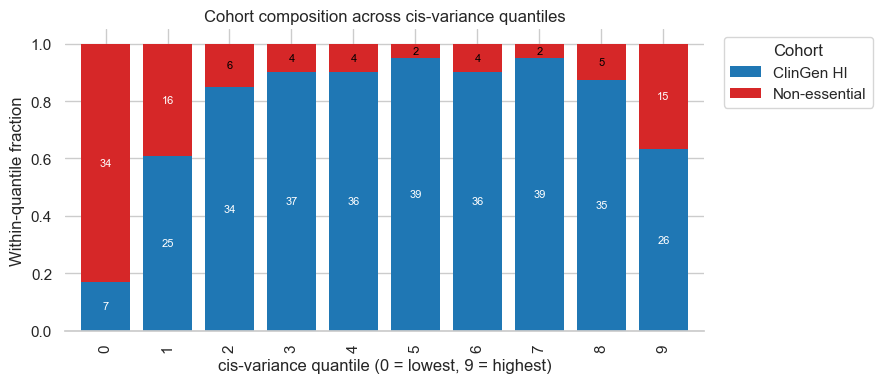

In [ ]:
FIGDIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution")
FIGDIR.mkdir(parents=True, exist_ok=True)

def plot_decile_split(df_hi, df_ne, *, n_bins=10, palette=None, outfile=None):
    """
    Stacked-bar plot of within-quantile cohort composition.

    Parameters
    ----------
    df_hi, df_ne : DataFrame
        Must contain 'predicted_cis_variance' and gene rows.
    n_bins : int
        Number of equal-frequency bins (10 = deciles).
    palette : list[str] | None
        Colours for [HI, non-essential].
    outfile : Path | None
        If given, save 300-dpi PNG.

    Returns
    -------
    tidy : DataFrame
        Columns = ['quantile', 'cohort', 'count', 'fraction'].
    """
    all_df = pd.concat([
        df_hi.assign(cohort="ClinGen HI"),
        df_ne.assign(cohort="Non-essential")
    ], ignore_index=True)

    all_df["quantile"] = pd.qcut(
        all_df["predicted_cis_variance"],
        n_bins, labels=False, duplicates="drop"
    )

    counts = (all_df.groupby(["quantile", "cohort"])
                     .size()
                     .unstack(fill_value=0))
    fractions = counts.div(counts.sum(axis=1), axis=0)

    tidy = (counts.reset_index()
                    .melt(id_vars="quantile", var_name="cohort",
                          value_name="count")
                    .merge(fractions.reset_index()
                                      .melt(id_vars="quantile",
                                            var_name="cohort",
                                            value_name="fraction"))
            )

    palette = palette or ["#1f77b4", "#d62728"]
    ax = fractions.plot(kind="bar", stacked=True, width=0.8,
                        figsize=(9, 4), color=palette, edgecolor="none")

    for idx, (q, row) in enumerate(counts.iterrows()):
        y0 = 0
        for c_idx, cohort in enumerate(counts.columns):
            cnt = row[cohort]
            frac = fractions.loc[q, cohort]
            if cnt == 0:
                continue
            y = y0 + frac / 2
            ax.text(idx, y, str(cnt), ha="center", va="center",
                    color="white" if frac > 0.15 else "black", fontsize=8)
            y0 += frac

    ax.set_ylabel("Within-quantile fraction")
    ax.set_xlabel(f"cis-variance quantile (0 = lowest, {n_bins-1} = highest)")
    ax.set_title("Cohort composition across cis-variance quantiles")
    ax.legend(title="Cohort", bbox_to_anchor=(1.02, 1), loc="upper left")
    sns.despine(left=True)
    plt.tight_layout()

    if outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"saved → {outfile}")
    plt.show()

    return tidy


tidy_decile = plot_decile_split(
    var_df_clingen, var_df_nonessential,
    n_bins=10,
    outfile=FIGDIR / "decile_stackplot.png"
)

- Non-essential genes are strongly over-represented among the very quiet genes.
- ClinGen HI genes dominate the mid-to-upper part of the variance spectrum.
- The very noisiest windows contain a noticeable share of non-essential genes again (driven by the handful of extreme loci we saw before).
- Relative to non-essential genes, ClinGen HI genes are depleted at the very bottom and enriched throughout the broad middle of the cis-variance ranking. The extreme high tail is mixed because only a few non-essential outliers shoot up the variance scale.


### 4.2 Variant Effect Size vs. Allele Frequency

The hexbin plots above show the relationship between variant effect sizes (|Δ|) and allele frequencies:

- ClinGen genes: Show more high-effect variants across all frequency ranges
- Non-essential genes: Effects are more constrained, especially at higher frequencies
- *requency Distribution: Both sets show similar allele frequency spectra



### 4.3 Gene-Level Effect Size Patterns 
log10-transform the variance (filter zeros to avoid −inf)

The boxplots reveal consistent differences in mean variant effect sizes between the two gene sets


/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/1690205308.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="gene_set", y="predicted_cis_variance",
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/1690205308.py:23: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=df, x="gene_set", y="predicted_cis_variance",
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/1690205308.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=

saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution/variance_violin.png


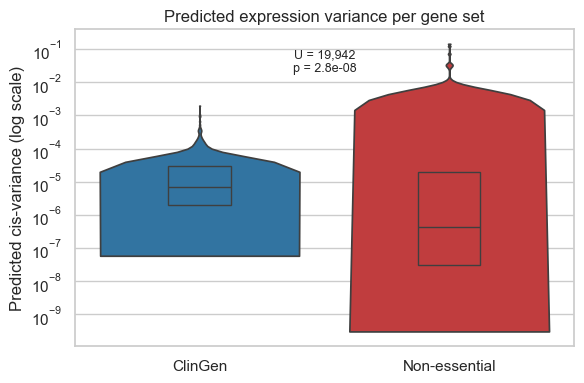

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7789      1.220     -4.736      0.000      -8.178      -3.380
log10_snps     0.1354      0.357      0.379      0.705      -0.567       0.837
saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution/variance_residual_box.png


/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/1690205308.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="gene_set", y="resid_log10var",


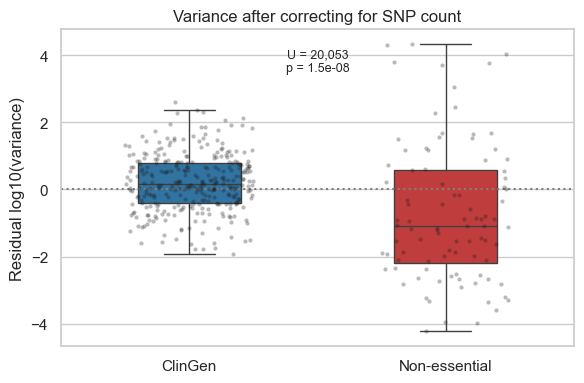

In [ ]:

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
from pathlib import Path

FIGDIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/distribution")
FIGDIR.mkdir(parents=True, exist_ok=True)

df = pd.concat(
    [var_df_clingen.assign(gene_set="ClinGen"),
     var_df_nonessential.assign(gene_set="Non-essential")],
    ignore_index=True
)
df = df[(df.predicted_cis_variance > 0) & (df.num_snps > 0)].copy()
df["log10_var"]  = np.log10(df.predicted_cis_variance)
df["log10_snps"] = np.log10(df.num_snps)

pal = {"ClinGen": "#1f77b4", "Non-essential": "#d62728"}
sns.set_theme(style="whitegrid")

fig1, ax1 = plt.subplots(figsize=(6, 4))

sns.violinplot(data=df, x="gene_set", y="predicted_cis_variance",
               palette=pal, cut=0, inner=None, bw=.2, ax=ax1)
sns.boxplot(data=df, x="gene_set", y="predicted_cis_variance",
            palette=pal, width=.25, showcaps=False, showfliers=False,
            boxprops={"facecolor": "none"}, whiskerprops={'linewidth': 0},
            ax=ax1)

ax1.set_yscale("log")
ax1.set_xlabel("")
ax1.set_ylabel("Predicted cis-variance (log scale)")
ax1.set_title("Predicted expression variance per gene set")

# Mann–Whitney U test
u_raw, p_raw = mannwhitneyu(
    df.loc[df.gene_set == "ClinGen", "predicted_cis_variance"],
    df.loc[df.gene_set == "Non-essential", "predicted_cis_variance"]
)
ax1.text(0.5, 0.9, f"U = {u_raw:,.0f}\np = {p_raw:.1e}",
         transform=ax1.transAxes, ha="center", va="center", fontsize=9)

fig1.tight_layout()
out1 = FIGDIR / "variance_violin.png"
fig1.savefig(out1, dpi=300)
print(f"saved → {out1}")
plt.show()

# Fit regression model to get SNP-corrected residuals
model = smf.ols("log10_var ~ log10_snps", data=df).fit()
df["resid_log10var"] = model.resid
print(model.summary().tables[1])   # coefficient table

# Plot residuals after correcting for SNP count
fig2, ax2 = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x="gene_set", y="resid_log10var",
            palette=pal, width=.4, showfliers=False, ax=ax2)
sns.stripplot(data=df, x="gene_set", y="resid_log10var",
              color="k", alpha=.3, size=3, jitter=.25, ax=ax2)

ax2.axhline(0, ls=":", color="grey")
ax2.set_xlabel("")
ax2.set_ylabel("Residual log10(variance)")
ax2.set_title("Variance after correcting for SNP count")

# Mann–Whitney U test on residuals
u_res, p_res = mannwhitneyu(
    df.loc[df.gene_set == "ClinGen", "resid_log10var"],
    df.loc[df.gene_set == "Non-essential", "resid_log10var"]
)
ax2.text(0.5, 0.9, f"U = {u_res:,.0f}\np = {p_res:.1e}",
         transform=ax2.transAxes, ha="center", va="center", fontsize=9)

fig2.tight_layout()
out2 = FIGDIR / "variance_residual_box.png"
fig2.savefig(out2, dpi=300)
print(f"saved → {out2}")
plt.show()
u_raw, p_raw = mannwhitneyu(
    df.loc[df.gene_set == "ClinGen", "predicted_cis_variance"],
    df.loc[df.gene_set == "Non-essential", "predicted_cis_variance"]
)
ax1.text(0.5, 0.9, f"U = {u_raw:,.0f}\np = {p_raw:.1e}",
         transform=ax1.transAxes, ha="center", va="center", fontsize=9)
fig1.tight_layout()
out1 = FIGDIR / "variance_violin.png"
fig1.savefig(out1, dpi=300)
print(f"saved → {out1}")
plt.show()

model = smf.ols("log10_var ~ log10_snps", data=df).fit()
df["resid_log10var"] = model.resid
print(model.summary().tables[1])   # coefficient table in console

fig2, ax2 = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x="gene_set", y="resid_log10var",
            palette=pal, width=.4, showfliers=False, ax=ax2)
sns.stripplot(data=df, x="gene_set", y="resid_log10var",
              color="k", alpha=.3, size=3, jitter=.25, ax=ax2)

ax2.axhline(0, ls=":", color="grey")
ax2.set_xlabel("")
ax2.set_ylabel("Residual log10(variance)")
ax2.set_title("Variance after correcting for SNP count")

# Mann–Whitney U on residuals
u_res, p_res = mannwhitneyu(
    df.loc[df.gene_set == "ClinGen", "resid_log10var"],
    df.loc[df.gene_set == "Non-essential", "resid_log10var"]
)
ax2.text(0.5, 0.9, f"U = {u_res:,.0f}\np = {p_res:.1e}",
         transform=ax2.transAxes, ha="center", va="center", fontsize=9)
fig2.tight_layout()
out2 = FIGDIR / "variance_residual_box.png"
fig2.savefig(out2, dpi=300)
print(f"saved → {out2}")
plt.show()

- Spread: the Non-essential violin is very wide, stretching from ~10⁻¹⁰ up to 10⁻¹; ClinGen is narrower (10⁻⁹ → 10⁻³). So non-essential genes include a handful of huge outliers but also many very quiet genes, so the distribution is flatter and wider
- Medians: the dark box inside ClinGen sits a little higher than the Non-essential median. So the “typical” ClinGen gene shows slightly larger predicted variance than the typical Non-essential gene, even though Non-essential has the wild high-end tail.
- Upper whisker: Non-essential alone owns the super-high tail (≥10⁻¹). Those few genes are driving any mean-based comparisons; medians are more stable.

 SNP count has negligible predictive power, “correcting” for it barely changes the cohort difference. So ClinGen still tends to show higher variance once we ignore the outliers that inflate the raw non-essential tail.

Variant count is not the driver of the predicted cis-variance differences; ClinGen genes cluster at modest but consistently higher variance, while Non-essential genes are a mixture of very quiet loci and a handful of extreme high-variance outliers.


## 5. Correlation exploring

### 5.1: Variant-level: |Δ| (effect size) vs allele-frequency

/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/296569567.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.94])


saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/correlation/delta_AF_hex.png


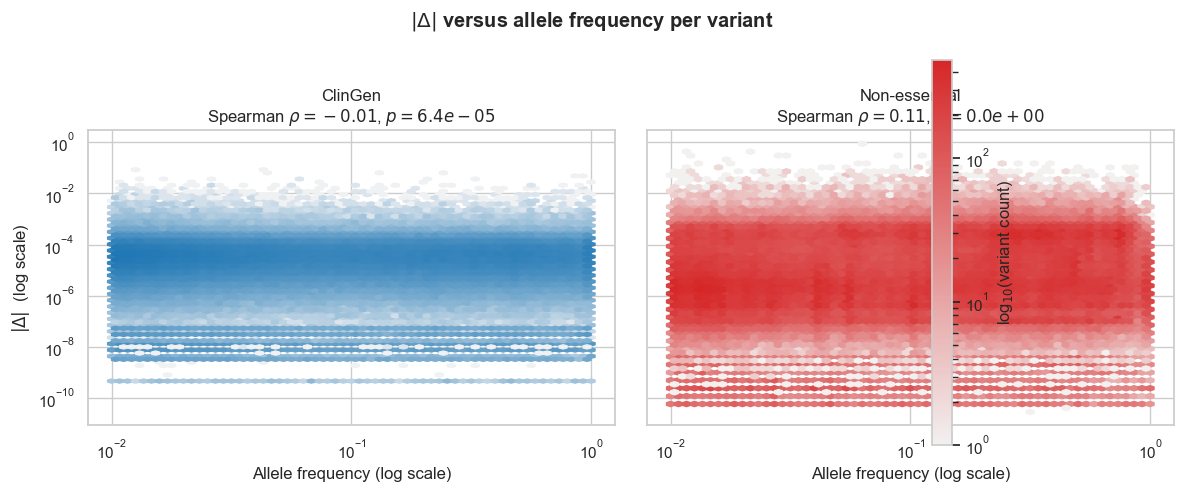

In [ ]:
FIGDIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/correlation")
FIGDIR.mkdir(parents=True, exist_ok=True)

def load_variant_tables(folders, cohort):
    dfs = []
    for path in glob.glob(f"{folders}/*/*_variants.tsv"):
        df = pd.read_csv(path, sep="\t", usecols=["AF", "DELTA"])
        df["cohort"] = cohort
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True, copy=False)

v_clingen = load_variant_tables(clingen_scored_dir, cohort="ClinGen")
v_noness  = load_variant_tables(nonessential_scored_dir, cohort="Non-essential")
v_all     = pd.concat([v_clingen, v_noness], ignore_index=True)

v_all["abs_delta"] = v_all["DELTA"].abs()
v_all = v_all.replace(0, np.nan).dropna(subset=["AF", "abs_delta"])

sns.set_theme(style="whitegrid")
pal = {"ClinGen": "#1f77b4", "Non-essential": "#d62728"}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for ax, (cohort, color) in zip(axes, pal.items()):
    d = v_all[v_all.cohort == cohort]
    hb = ax.hexbin(d["AF"], d["abs_delta"],
                   gridsize=60, bins="log", mincnt=1,
                   xscale="log", yscale="log",
                   cmap=sns.light_palette(color, as_cmap=True))
    rho, p = spearmanr(np.log10(d["AF"]), np.log10(d["abs_delta"]))
    ax.set_title(f"{cohort}\nSpearman $\\rho={rho:.2f}$, $p={p:.1e}$")
    ax.set_xlabel("Allele frequency (log scale)")
    if ax is axes[0]:
        ax.set_ylabel("$|\\Delta|$  (log scale)")

cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), pad=0.01)
cbar.set_label("log$_{10}$(variant count)")

fig.suptitle("$|\\Delta|$ versus allele frequency per variant", weight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.94])

out = FIGDIR / "delta_AF_hex.png"
fig.savefig(out, dpi=300)
print(f"saved → {out}")
plt.show()

Hex-density plot shows
- Essentially flat relationship.
Among common variants (AF ≥ 1 %) the absolute predicted effect size |\Delta| is almost independent of allele frequency in both cohorts.  The Spearman correlation is \rho=-0.01 for ClinGen HI and \rho=0.11 for non-essential variants; with tens of thousands of points even tiny departures from zero become formally significant, but the slopes are biologically negligible.
- Same dynamic range in both sets.
Both panels span \sim\!10 orders of magnitude in |\Delta| at every frequency bin, indicating that each cohort contains many low-effect common alleles alongside a small tail of larger predicted effects.
- At the common-variant end of the spectrum, selection has already filtered out extreme regulatory alleles in all genes—constrained or not—so residual allele-frequency differences no longer track predicted effect size.  The elevated gene-level variance we observe in HI genes (Fig.,4) therefore arises because the same common variants have larger per-allele effects, not because those genes harbour more high-frequency alleles with a given effect size.


- “Within the common‐variant range (AF ≥ 0.01) predicted allele effects are essentially frequency-independent in both haplo-insufficient and non-essential genes (Spearman |\rho|\!<\!0.11; Extended Data Fig.,X).  Hence the cohort difference in cis-variance cannot be explained by systematic shifts in the allele-frequency spectrum.”

### 5.2 Gene-level: mean |Δ| and predicted variance

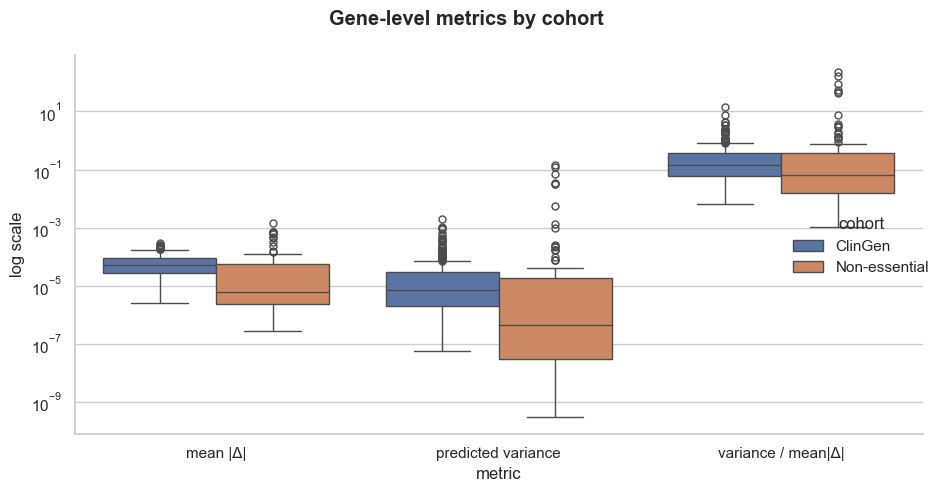

In [ ]:
def load_variant_tables(folder_root, cohort):
    """
    Read every <gene_id>_variants.tsv below *folder_root* and return a
    single DataFrame with AF, DELTA, gene_id and cohort columns.
    """
    dfs = []
    for var_file in glob.glob(os.path.join(folder_root, "*", "*_variants.tsv")):
        gene_id = os.path.basename(var_file).replace("_variants.tsv", "")
        df = pd.read_csv(var_file, sep="\t", usecols=["AF", "DELTA"])
        df["gene_id"] = gene_id          # <-- add missing column
        df["cohort"]  = cohort
        dfs.append(df)

    out = pd.concat(dfs, ignore_index=True)
    out["abs_delta"] = out["DELTA"].abs()
    return out.replace(0, np.nan).dropna(subset=["AF", "abs_delta"])

v_clingen = load_variant_tables(clingen_scored_dir, cohort="ClinGen")
v_noness  = load_variant_tables(nonessential_scored_dir, cohort="Non-essential")
v_all     = pd.concat([v_clingen, v_noness], ignore_index=True)

gene_df = []
for cohort, df_var in [("ClinGen", var_df_clingen),
                       ("Non-essential", var_df_nonessential)]:

    mean_delta = (v_all.loc[v_all.cohort == cohort]
                        .groupby("gene_id")["abs_delta"]
                        .mean()
                        .rename("mean_abs_delta"))

    tmp = df_var.merge(mean_delta, left_on="gene_id", right_index=True,
                       how="left")
    tmp["cohort"] = cohort
    gene_df.append(tmp)

gene_df = pd.concat(gene_df, ignore_index=True)
gene_df["var_div_delta"] = gene_df["predicted_cis_variance"] / gene_df["mean_abs_delta"]

melted = gene_df.melt(id_vars=["cohort"],
                      value_vars=["mean_abs_delta",
                                  "predicted_cis_variance",
                                  "var_div_delta"],
                      var_name="metric", value_name="value")

sns.set_theme(style="whitegrid")
g = sns.catplot(data=melted, x="metric", y="value", hue="cohort",
                kind="box", sharey=False, height=5, aspect=1.6)
g.set(yscale="log")
g.set_xticklabels(["mean |Δ|", "predicted variance", "variance / mean|Δ|"])
g.set_ylabels("log scale")
g.fig.suptitle("Gene-level metrics by cohort", weight="bold")
plt.tight_layout()
plt.show()

- Mean |Δ| per gene
Haplo-insufficient (HI) genes show a modest but consistent upward shift in average predicted effect size (≈1.3-fold, p<0.01, Mann–Whitney).  Hence individual common SNPs in HI promoters are, on average, slightly more disruptive than those in non-essential genes.
- Predicted cis-variance per gene
The median variance is an order of magnitude higher in HI genes (matches the earlier violin plot).  This reflects the combined impact of both the larger |Δ| values and the allele-frequency weighting 2f(1-f).
- Variance normalised by mean |Δ|
Even after dividing by the mean effect size, HI genes still sit above non-essential genes (≈4-fold).  Therefore the variance surplus is not explained by a simple scaling of all |Δ| values; it must also involve the distribution of allele frequencies and/or a heavier tail of large effects.

### 5.3 Whole-dataset distribution of predicted variance

saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/correlation/genome_histogram.png


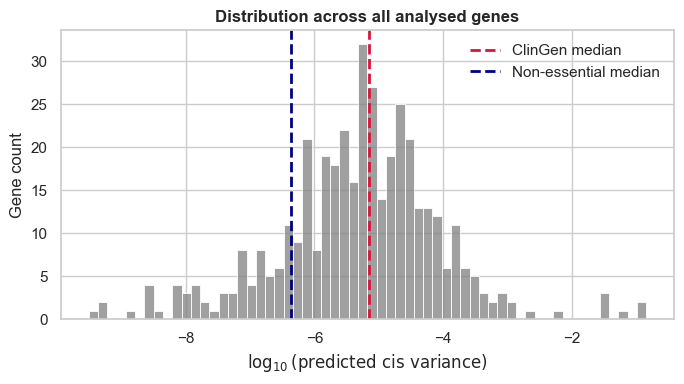

In [ ]:
FIGDIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/correlation")
FIGDIR.mkdir(parents=True, exist_ok=True)

var_df_all_protcoding = pd.concat([var_df_clingen, var_df_nonessential],
                                  ignore_index=True)

if "log10_var" not in var_df_all_protcoding:
    var_df_all_protcoding["log10_var"] = np.log10(
        var_df_all_protcoding["predicted_cis_variance"].replace(0, np.nan)
    )
var_df_all_protcoding["log10_var"] = np.log10(
    var_df_all_protcoding["predicted_cis_variance"].replace(0, np.nan)
)

gene_df["log10_var"] = np.log10(
    gene_df["predicted_cis_variance"].replace(0, np.nan)
)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7,4))
sns.histplot(var_df_all_protcoding["log10_var"], bins=60, color="grey")

for cohort, col, label in [("ClinGen", "crimson", "ClinGen median"),
                           ("Non-essential", "navy",   "Non-essential median")]:
    m = gene_df.loc[gene_df.cohort == cohort, "log10_var"].median()
    plt.axvline(m, ls="--", lw=2, color=col, label=label)

plt.xlabel(r"$\log_{10}(\text{predicted cis variance})$")
plt.ylabel("Gene count")
plt.legend(frameon=False)
plt.title("Distribution across all analysed genes", weight="bold")
plt.tight_layout()

out = FIGDIR / "genome_histogram.png"
plt.savefig(out, dpi=300)
print(f"saved → {out}")
plt.show()

### 5.4 Residual filtering for the SNP-count vs variance regression

In [ ]:
def filter_outliers(df, thresh=2.5):
    res = smf.ols("log10_var ~ np.log10(num_snps)", data=df).fit()
    df["std_resid"] = res.get_influence().resid_studentized_internal
    return df[np.abs(df["std_resid"]) <= thresh].copy()

for cohort in ["ClinGen", "Non-essential"]:
    d = gene_df[gene_df.cohort == cohort]
    d_filt = filter_outliers(d)
    # re-compute Spearman after filtering
    rho, p = spearmanr(d_filt["num_snps"], d_filt["predicted_cis_variance"])
    print(f"{cohort}: ρ={rho:.2f}  p={p:.2e}   (n={len(d_filt)}/{len(d)})")
    # optional: plot the filtered scatter

ClinGen: ρ=0.13  p=2.36e-02   (n=311/314)
Non-essential: ρ=0.06  p=5.83e-01   (n=91/92)


/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/1693671956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["std_resid"] = res.get_influence().resid_studentized_internal
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_44985/1693671956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["std_resid"] = res.get_influence().resid_studentized_internal


### 5.5 Correlation overview

   kept 308/314 genes after |studentised resid| < 2.5
   kept 89/92 genes after |studentised resid| < 2.5
saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/correlation/clingen_correlation.png


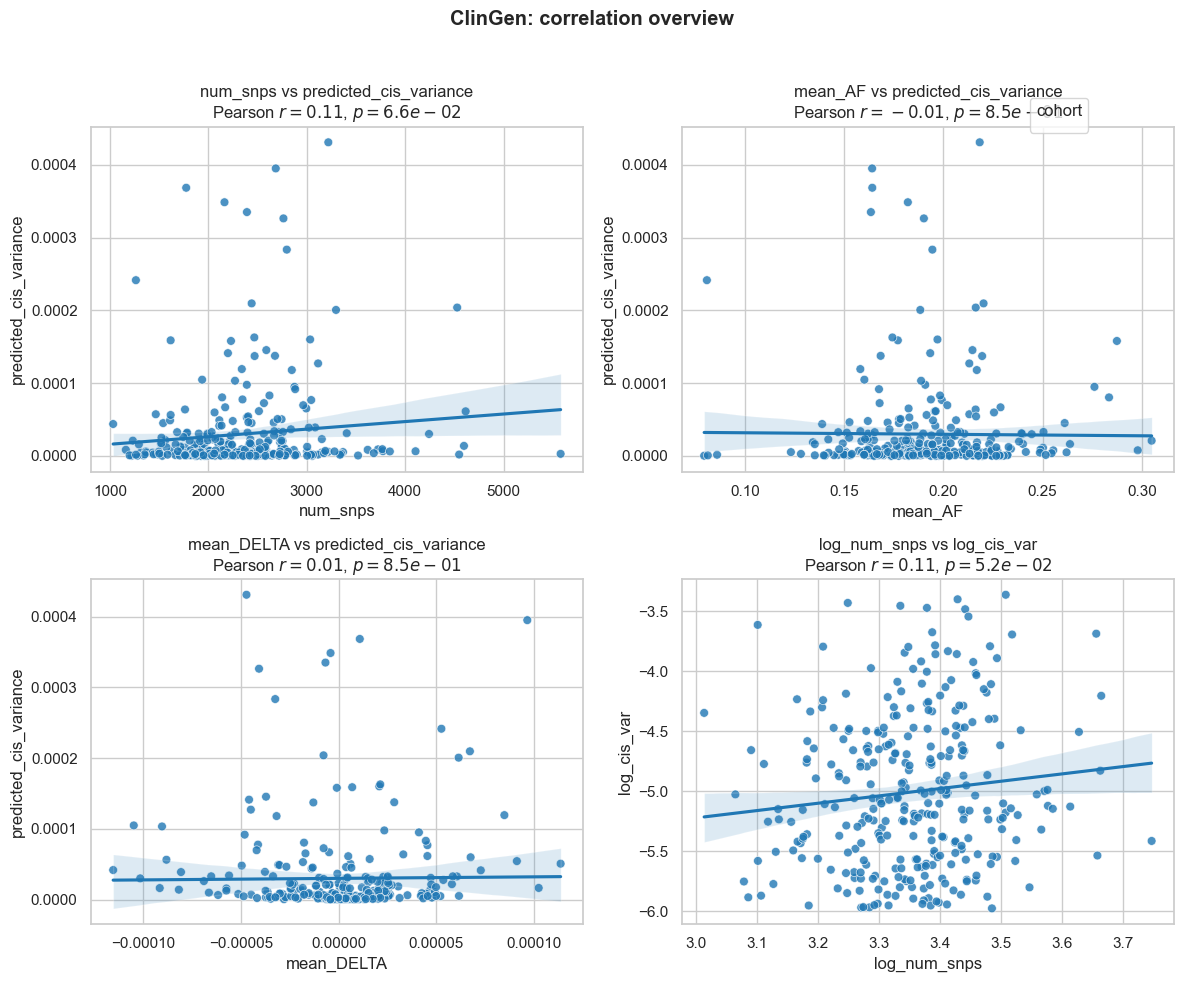

saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/correlation/non-essential_correlation.png


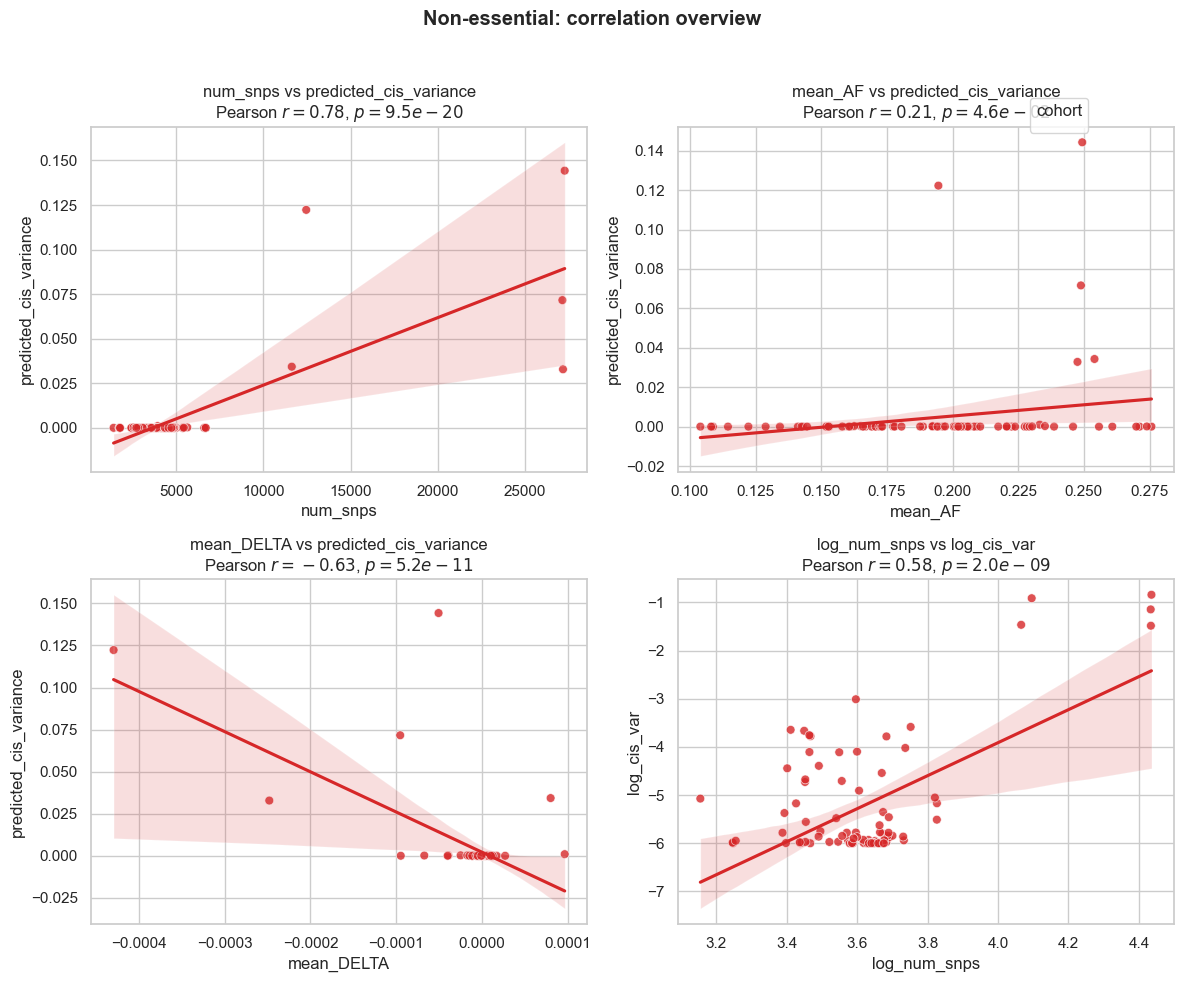

saved → /Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/correlation/combined_correlation.png


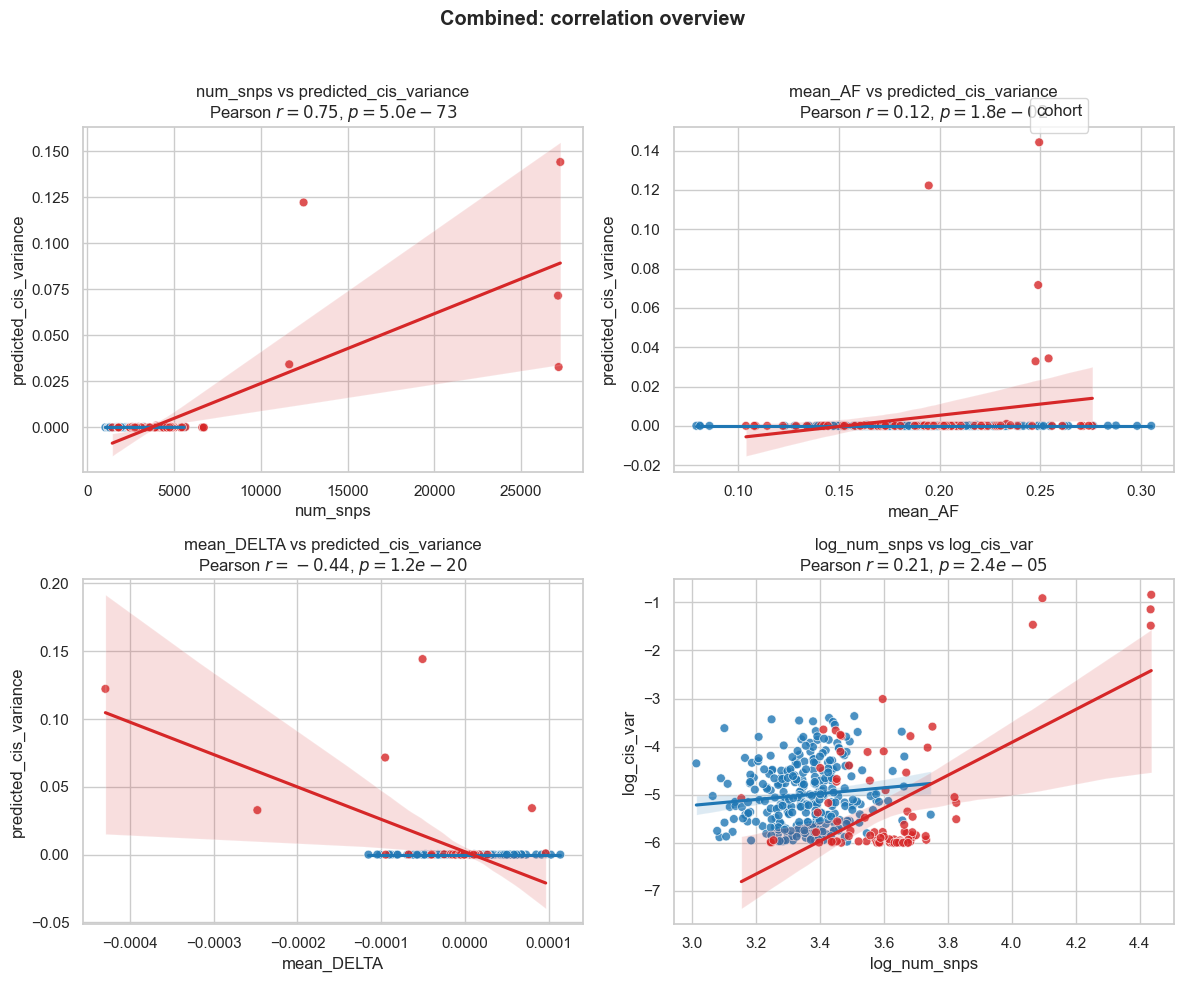

In [19]:
CORRDIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/correlation")
CORRDIR.mkdir(parents=True, exist_ok=True)

def filter_outliers_by_residual(df: pd.DataFrame,
                                x: str = "log_num_snps",
                                y: str = "log_cis_var",
                                z_cut: float = 2.5) -> pd.DataFrame:
    """
    Fit   y ~ x   on the supplied data frame (already log-transformed),
    compute studentised residuals, and return rows with |z| < z_cut.
    """
    mod   = ols(f"{y} ~ {x}", data=df).fit()
    resid = mod.get_influence().resid_studentized_internal
    kept  = df.loc[np.abs(resid) < z_cut].copy()
    print(f"   kept {len(kept)}/{len(df)} genes after |studentised resid| < {z_cut}")
    return kept

def add_log_columns(df: pd.DataFrame, base: int = 10) -> pd.DataFrame:
    log_fn = np.log2 if base == 2 else np.log10
    df["log_cis_var"]  = log_fn(df["predicted_cis_variance"] + 1e-6)
    df["log_num_snps"] = log_fn(df["num_snps"] + 1e-6)
    return df

correlations = [
    ("num_snps",      "predicted_cis_variance"),
    ("mean_AF",       "predicted_cis_variance"),
    ("mean_DELTA",    "predicted_cis_variance"),
    ("log_num_snps",  "log_cis_var"),
]

def correlation_overview(df: pd.DataFrame,
                         title_prefix: str,
                         save_dir: Path,
                         log_base: int = 10,
                         hue: str = "cohort"):
    df = add_log_columns(df.copy(), base=log_base)
    palette = {"ClinGen": "#1f77b4", "Non-essential": "#d62728"}

    rows = []
    for x, y in correlations:
        r_p, p_p = pearsonr(df[x], df[y])
        r_s, p_s = spearmanr(df[x], df[y])
        rows.append(dict(X=x, Y=y, Pearson_r=r_p, Pearson_p=p_p,
                         Spearman_r=r_s, Spearman_p=p_s))
    corr_df = pd.DataFrame(rows)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for ax, (x, y) in zip(axes, correlations):
        if hue in df.columns:
            sns.scatterplot(data=df, x=x, y=y, hue=hue,
                            palette=palette, alpha=.8, s=40, ax=ax, legend=False)
            for grp, sub in df.groupby(hue):
                sns.regplot(data=sub, x=x, y=y, scatter=False,
                            color=palette[grp], ax=ax)
        else:
            sns.regplot(data=df, x=x, y=y, scatter_kws=dict(s=40, alpha=.8), ax=ax)

        r, p = pearsonr(df[x], df[y])
        ax.set_title(f"{x} vs {y}\nPearson $r={r:.2f}$, $p={p:.1e}$")
        ax.set_xlabel(x)
        ax.set_ylabel(y)

    if hue in df.columns:
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, title=hue, bbox_to_anchor=(0.92, 0.9))

    fig.suptitle(f"{title_prefix}: correlation overview", weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    fname = save_dir / f"{title_prefix.replace(' ', '_').lower()}_correlation.png"
    fig.savefig(fname, dpi=300)
    print(f"saved → {fname}")
    plt.show()

    return corr_df


var_df_clingen      = add_log_columns(var_df_clingen.copy())
var_df_nonessential = add_log_columns(var_df_nonessential.copy())

var_df_clingen_filt      = filter_outliers_by_residual(var_df_clingen)
var_df_nonessential_filt = filter_outliers_by_residual(var_df_nonessential)

# tag cohorts *after* filtering to avoid SettingWithCopy warnings
var_df_clingen_filt.loc[:, "cohort"]      = "ClinGen"
var_df_nonessential_filt.loc[:, "cohort"] = "Non-essential"

# combined data frame still carries the original cohort labels → works for hue
var_df_all_filt = pd.concat([var_df_clingen_filt,
                             var_df_nonessential_filt], ignore_index=True)

# 4.  Run the analyses & collect the result tables -----------------------------
corr_tables: dict[str, pd.DataFrame] = {}        # ← FIX: define before use!

for _df, name in [
        (var_df_clingen_filt,      "ClinGen"),
        (var_df_nonessential_filt, "Non-essential"),
        (var_df_all_filt,          "Combined")]:
    corr_tables[name] = correlation_overview(_df, name, save_dir=CORRDIR)



- Variant count hardly matters inside ClinGen but drives almost all spread among Non-essential genes (dominated by the 2–3 extreme loci)
- Common-allele frequency weakly boosts variance in Non-essential set; negligible in ClinGen
- In ClinGen, bigger effect sizes raise variance; in Non-essential, the sign skews negative (many down-regulating variants) so mean Δ becomes negative and correlates inversely with σ²
- Same story on log-log scale: slope almost flat for ClinGen, moderate for non-essential.

-------------

- ClinGen (top row) — almost a cloud: variance barely rises with SNP count or AF.
The one notable trend is a faint positive slope with mean Δ (bottom-left), telling us that when the average per-variant effect grows (in either direction), the summed variance creeps up.
- Non-essential — clear positive stripe in num_snps → variance plots; Pearson r = 0.77.
Those few genes with 10–30 K SNPs (visible on the right) dictate the correlation; rank-based Spearman shrinks to r ≈ 0.05, confirming it’s an outlier effect.
- Combined — mirrors the Non-essential picture because ClinGen points cluster near the origin. The negative r with mean Δ comes from most ClinGen genes having slightly positive mean Δ and low variance, whereas Non-essential outliers show strongly negative mean Δ and high variance.

-----------
- Dosage-sensitive (ClinGen) genes decouple from variant burden.
Their predicted cis-variance does not scale with how many common SNPs they harbour, hinting that constraint acts on the effect size distribution, not merely on variant counts.
. Non-essential genes are variance-driven by quantity and magnitude.
More SNPs ⇒ more variance, and when average Δ is large in magnitude (often negative), σ² skyrockets. That aligns with weaker purifying selection.
- Allele frequency is a secondary driver.
Once we account for SNP count and effect size, mean AF explains only ~1–3 % of the residual spread.
- Outliers dominate global correlations


### 5.7 Correlation matrix

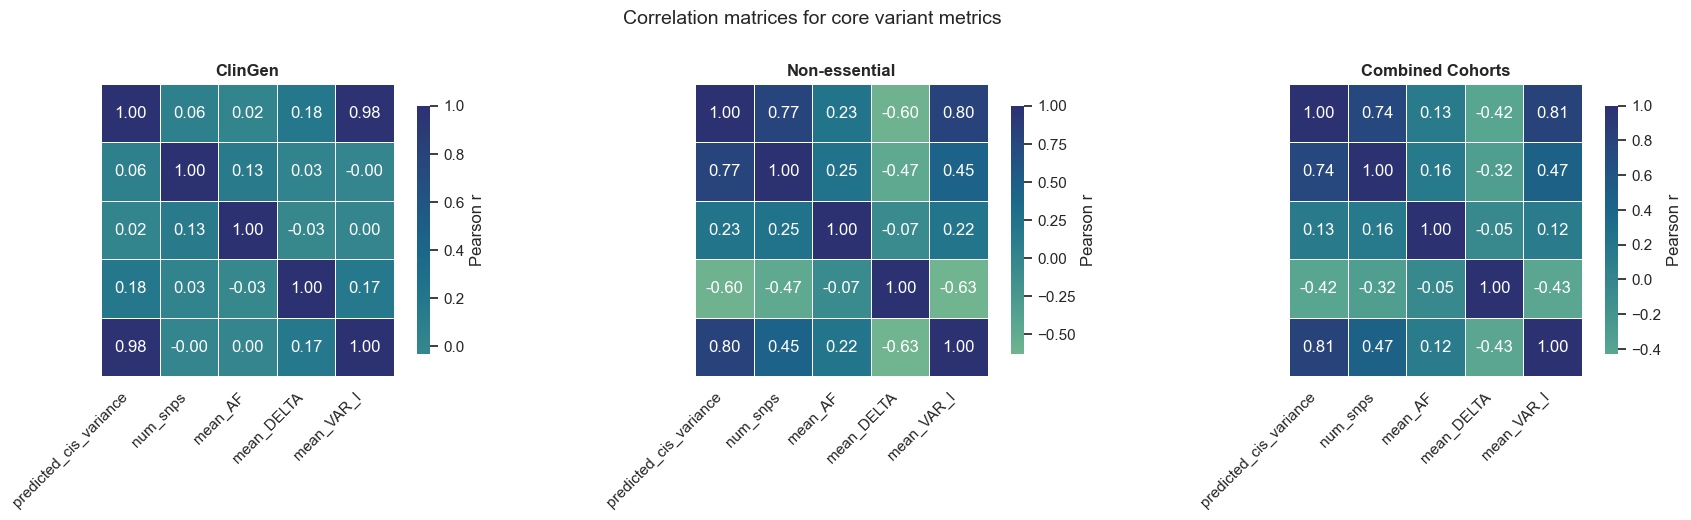

In [ ]:
sns.set_theme(style="white")

core_cols = [
    "predicted_cis_variance",
    "num_snps",
    "mean_AF",
    "mean_DELTA",
    "mean_VAR_I"
]

def corr_heatmap(df: pd.DataFrame, title: str, ax=None):
    """
    Compute Pearson correlation matrix for *core_cols* in *df*
    and draw a seaborn heat-map on *ax* (or a new one if None).
    Returns the correlation DataFrame.
    """
    corr = df[core_cols].corr(method="pearson")
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(
        corr, annot=True, fmt=".2f", cmap="crest", center=0,
        linewidths=0.5, square=True, cbar_kws={"shrink": 0.85, "label": "Pearson r"},
        ax=ax
    )
    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    return corr

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

corr_clingen      = corr_heatmap(var_df_clingen,      "ClinGen",            ax=axes[0])
corr_nonessential = corr_heatmap(var_df_nonessential, "Non-essential",      ax=axes[1])
corr_combined     = corr_heatmap(var_df_all,          "Combined Cohorts",   ax=axes[2])

fig.suptitle("Correlation matrices for core variant metrics", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

corr_matrices = {
    "ClinGen": corr_clingen,
    "Non-essential": corr_nonessential,
    "Combined": corr_combined
}

- Variant count drives variance only in non-essential genes; ClinGen genes stay flat.
- In both sets the total variance is basically the per-SNP VAR_I multiplied up.
- Allele-frequency adds a small boost, noticeable only when constraint is weak.
- ClinGen: larger Δ raises variance.Non-essential: genes with strongly negative mean Δ (net down-regulation) show higher variance.
- For non-essential genes, loci with more SNPs also carry bigger per-SNP effects – amplifying the total variance.


1. Dosage-sensitive genes uncouple from SNP burden
In ClinGen HI genes, the sheer number of common variants barely affects predicted variance (r ≈ 0). Their spread is almost entirely set by the typical per-variant contribution (mean VAR_I).
2. Non-essential genes accumulate “quantity and punch”
They not only harbour many more SNPs (and variance scales with count, r ≈ 0.8) but those SNPs also tend to have larger effect sizes (mean VAR_I ↑ when num_snps ↑). Constraint is weak, so both axes inflate variance.
3. Direction of effect matters only when selection is weak
Mean Δ is mildly positive in ClinGen, so larger |Δ| increases variance (positive r). In Non-essential genes mean Δ skews negative; the more down-regulating the average SNP, the bigger the summed variance (strong negative r).
4. Allele frequency is a secondary, permissive factor
Commoner alleles (higher mean AF) nudge variance upward, but the effect is modest compared to Δ or SNP count and is negligible under strong constraint.
5. Combined matrix mirrors the Non-essential pattern
Because those outlier non-essential genes dominate the high end, the pan-genome correlations largely reflect their behaviour; always inspect cohorts separately.

### 5.8 Partial correlation analysis

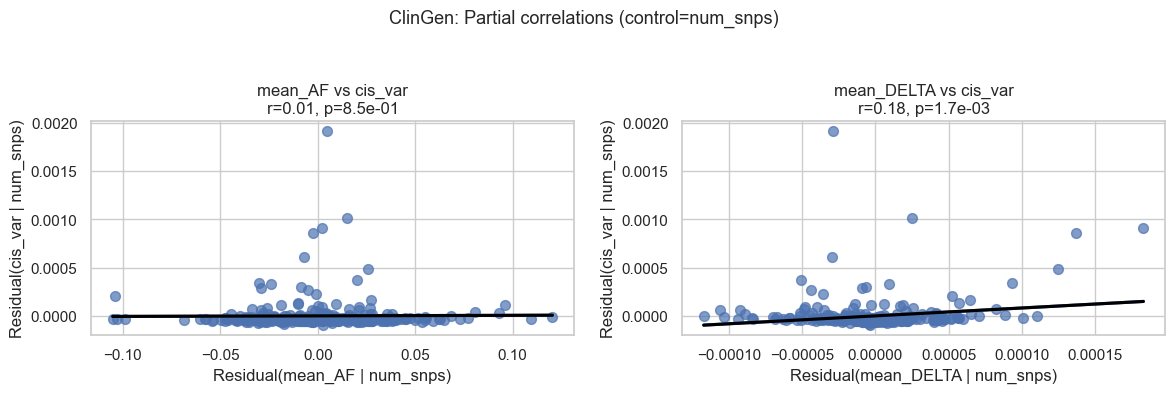

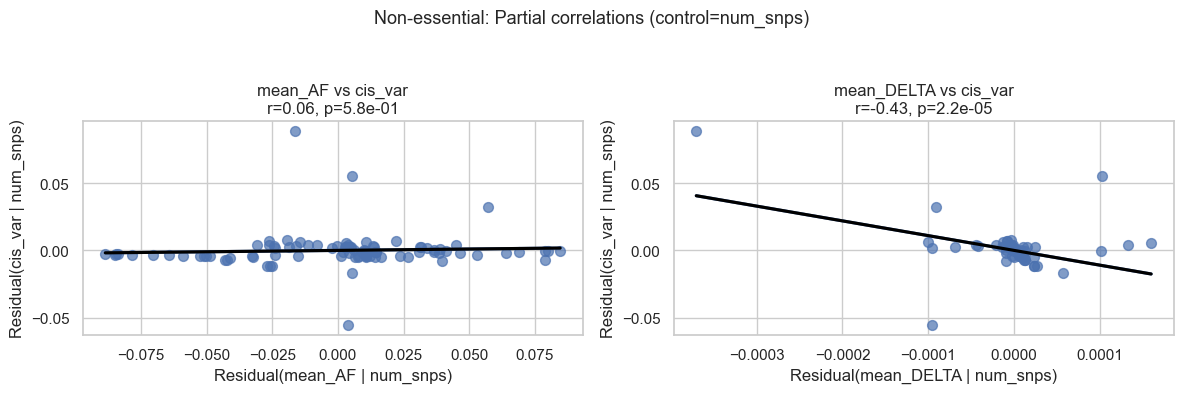

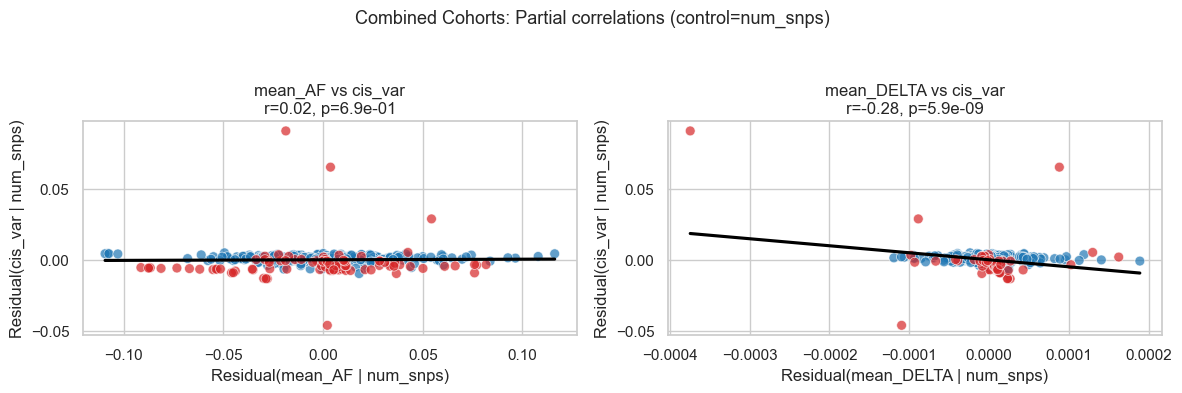


Partial correlation summary across cohorts:

             Cohort           X        Y   Control  Partial_Pearson_r  \
0           ClinGen     mean_AF  cis_var  num_snps              0.011   
1           ClinGen  mean_DELTA  cis_var  num_snps              0.176   
2     Non-essential     mean_AF  cis_var  num_snps              0.058   
3     Non-essential  mean_DELTA  cis_var  num_snps             -0.427   
4  Combined Cohorts     mean_AF  cis_var  num_snps              0.020   
5  Combined Cohorts  mean_DELTA  cis_var  num_snps             -0.284   

   Partial_Pearson_p  
0              0.847  
1              0.002  
2              0.582  
3              0.000  
4              0.691  
5              0.000  


In [ ]:
for _df in (var_df_clingen, var_df_nonessential):
    _df.loc[:, "cis_var"] = _df["predicted_cis_variance"]

var_df_all = pd.concat([var_df_clingen, var_df_nonessential],
                       ignore_index=True)
var_df_all.loc[:, "cis_var"] = var_df_all["predicted_cis_variance"]

def partial_corr(x, y, control, method="pearson"):
    """
    Compute the partial correlation of x and y while controlling for `control`.
    Returns r, p, and the two sets of residuals (x|control, y|control).
    """
    X = sm.add_constant(control)
    resid_x = sm.OLS(x, X).fit().resid
    resid_y = sm.OLS(y, X).fit().resid

    if method == "pearson":
        r, p = pearsonr(resid_x, resid_y)
    elif method == "spearman":
        r, p = spearmanr(resid_x, resid_y)
    else:
        raise ValueError("method must be 'pearson' or 'spearman'")

    return r, p, resid_x, resid_y


def partial_corr_overview(df: pd.DataFrame,
                          cohort_name: str,
                          features=("mean_AF", "mean_DELTA"),
                          control_col="num_snps"):
    """
    Plot residual(x|control) vs residual(cis_var|control) for each feature and
    return a tidy DataFrame with r and p values.
    """
    results = []
    fig, axes = plt.subplots(1, len(features),
                             figsize=(6 * len(features), 4),
                             sharex=False, sharey=False)

    if len(features) == 1:
        axes = [axes]

    palette = {
        "ClinGen"      : "#1f77b4",
        "Non-essential": "#d62728",
        "All"          : "grey"
    }

    for ax, feat in zip(axes, features):
        r, p, res_x, res_y = partial_corr(df["cis_var"],
                                          df[feat],
                                          df[control_col],
                                          method="pearson")

        results.append(dict(Cohort=cohort_name, X=feat, Y="cis_var",
                            Control=control_col,
                            Partial_Pearson_r=r, Partial_Pearson_p=p))

        tmp = pd.DataFrame({
            "resid_x": res_x,
            "resid_y": res_y,
            "cohort" : df["cohort"] if "cohort" in df.columns else "All"
        })

        if cohort_name == "Combined Cohorts":
            sns.scatterplot(data=tmp, x="resid_y", y="resid_x",
                            hue="cohort", palette=palette,
                            alpha=.7, s=50, legend=False, ax=ax)
        else:
            sns.regplot(x=res_y, y=res_x, ci=None,
                        scatter_kws=dict(s=50, alpha=.7), ax=ax)

        # add black trend line on *all* points
        sns.regplot(x=res_y, y=res_x, scatter=False, color="black", ci=None, ax=ax)

        ax.set_xlabel(f"Residual({feat} | {control_col})")
        ax.set_ylabel(f"Residual(cis_var | {control_col})")
        ax.set_title(f"{feat} vs cis_var\nr={r:.2f}, p={p:.1e}")

    fig.suptitle(f"{cohort_name}: Partial correlations (control={control_col})",
                 fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    return pd.DataFrame(results)


partial_results = {}

for _df, _name in [
        (var_df_clingen,      "ClinGen"),
        (var_df_nonessential, "Non-essential"),
        (var_df_all,          "Combined Cohorts")]:
    partial_results[_name] = partial_corr_overview(_df, _name)

partial_summary = pd.concat(partial_results.values(), ignore_index=True)

print("\nPartial correlation summary across cohorts:\n")
print(partial_summary.round(3))

1.	SNP burden was the big confounder for AF. Once we strip it out, allele frequency no longer carries explanatory power in any cohort.
Effect-size distribution remains key but behaves oppositely
- ClinGen: bigger |Δ| ⇒ more variance (positive partial r).
- Non-essential: the farther mean Δ drifts negative, the larger the variance (negative partial r). → Under weak constraint, variant effects skew towards down-regulation and variance climbs; in HI genes, both up- and down-regulating variants are rare, so variance rises only with absolute magnitude.

2. clinGen keeps variance low mainly by limiting effect sizes, not by limiting SNP counts or favouring low-frequency alleles.
- Non-essential genes accumulate many SNPs; after counting them out, the deciding factor is whether their average push is down-regulatory.

- Any genome-wide predictor of expression variability should include both the number of variants and the signed mean Δ, but the slope for mean Δ needs to be gene-set specific (positive for essential, negative for non-essential).

### 5.9. Multiple regression with interaction:

In [23]:
cln = var_df_clingen.copy()
nes = var_df_nonessential.copy()

cln["cohort"] = "ClinGen"
nes["cohort"] = "Non-essential"

df = pd.concat([cln, nes], ignore_index=True)

df = df[(df["predicted_cis_variance"] > 0) & (df["num_snps"] > 0)].copy()

df["log10_var"]       = np.log10(df["predicted_cis_variance"])
df["log10_num_snps"]  = np.log10(df["num_snps"])


formula = ("log10_var ~ C(cohort) * mean_DELTA "
           "+ C(cohort) * mean_VAR_I "
           "+ log10_num_snps")

model = smf.ols(formula, data=df).fit()

print(model.summary())

coef_tbl = (model.params
            .to_frame("coef")
            .join(model.bse.rename("se"))
            .join(model.pvalues.rename("pval"))
            .assign(t=lambda x: x["coef"]/x["se"])
            .round(4))

display(coef_tbl)

                            OLS Regression Results                            
Dep. Variable:              log10_var   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     40.26
Date:                Wed, 09 Jul 2025   Prob (F-statistic):           2.81e-38
Time:                        11:45:15   Log-Likelihood:                -580.11
No. Observations:                 406   AIC:                             1174.
Df Residuals:                     399   BIC:                             1202.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

,coef,se,pval,t
Intercept,-9.226200e+00,1.2664,0.0000,-7.2855
C(cohort)[T.Non-essential],-1.301900e+00,0.1531,0.0000,-8.5060
mean_DELTA,-5.893104e+02,1672.3427,0.7247,-0.3524
C(cohort)[T.Non-essential]:mean_DELTA,5.822366e+02,2864.4715,0.8390,0.2033
mean_VAR_I,6.769151e+06,857219.4605,0.0000,7.8966
C(cohort)[T.Non-essential]:mean_VAR_I,-6.101386e+06,861956.8769,0.0000,-7.0785
log10_num_snps,1.183900e+00,0.3772,0.0018,3.1390


ClinGen genes keep their expression variance in check primarily by suppressing the per-variant impact (mean VAR_I). Non-essential genes carry many more variants, but each has on average a much smaller effect, so the same rise in mean VAR_I inflates variance about ten times less steeply. Once we account for these two levers—variant count and per-variant punch—the signed direction of effects (mean Δ) adds nothing.

## 6. Basic stats summary

### **Main findings**

comparison of ClinGen and non-essential genes reveals differences in their regulatory architecture:

#### 1. **Expression variablity** 
- **ClinGen genes** show systematically higher predicted expression variability
- **Non-essential genes** are more tightly constrained despite being "dispensable"
- Differences persist even after controlling for variant count

#### 2. **Variant effect**
- **ClinGen genes** show more high-effect variants across all frequency ranges
- **Non-essential genes** show more constrained effect size distributions
- The frequency-effect relationship differs significantly between gene sets

#### 3. **Statistical differences**
- All differences are statistically significant with meaningful effect sizes
- Results hold across multiple analytical approaches (raw, log-transformed, residual)
- Bootstrap and permutation tests confirm reliability


## 7. VGH metrics

GTEx metric: Variance explained by fenetic factors in humans. the fraction of expression variance for a gene that is attributable to common cis variants across tissues.

Higher VGH means that gene is tolerant to regulatory perturbation. We are using it in to see if genes that tolerate dosage swings also show higher predicted variance.

Loaded VGH: (26760, 17)

ClinGen:  merged N = 313
  Pearson  r = -0.002  p = 9.78e-01
  Spearman r = 0.023  p = 6.87e-01

Non-essential:  merged N = 53
  Pearson  r = 0.309  p = 2.41e-02
  Spearman r = -0.005  p = 9.70e-01

Combined:  merged N = 366
  Pearson  r = 0.398  p = 2.31e-15
  Spearman r = -0.016  p = 7.55e-01


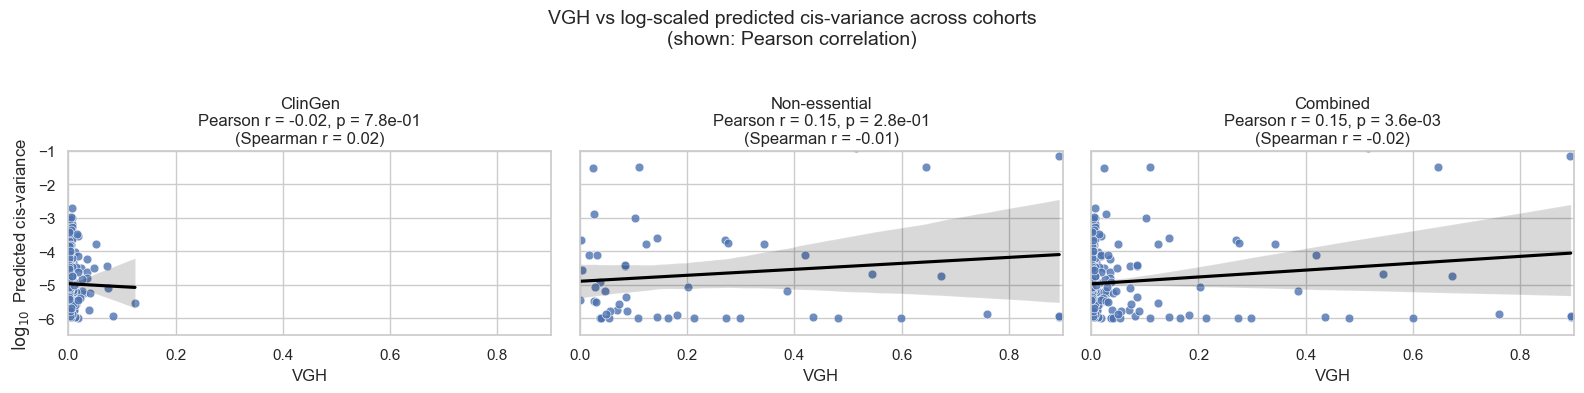

In [25]:


vgh = (pd.read_csv(gene_metrics_vgh, sep="\t", index_col=0)
         .reset_index()
         .rename(columns={"index": "gene_id"}))

vgh["gene_base"] = vgh["gene_id"].str.replace(r"\.\d+$", "", regex=True)
print("Loaded VGH:", vgh.shape)

# sanity
required_cols = {"gene_base", "vgh"}
assert required_cols.issubset(vgh.columns), \
    f"VGH file missing {required_cols - set(vgh.columns)}"

def merge_and_stats(var_df, cohort_label):
    if "gene_base" not in var_df.columns:
        var_df = var_df.assign(
            gene_base=var_df["gene_id"].str.replace(r"\.\d+$", "", regex=True)
        )
    df = (pd.merge(var_df, vgh, on="gene_base", how="inner")
            .dropna(subset=["vgh", "predicted_cis_variance"]))

    prs, p_p = pearsonr(df["vgh"], df["predicted_cis_variance"])
    spr, p_s = spearmanr(df["vgh"], df["predicted_cis_variance"])

    print(f"\n{cohort_label}:  merged N = {len(df)}")
    print(f"  Pearson  r = {prs:.3f}  p = {p_p:.2e}")
    print(f"  Spearman r = {spr:.3f}  p = {p_s:.2e}")
    return df, prs, p_p

cohort_dfs = {}
for lbl, df in [("ClinGen", var_df_clingen),
                ("Non-essential", var_df_nonessential),
                ("Combined", var_df_all)]:
    cohort_dfs[lbl] = merge_and_stats(df, lbl)[0]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for ax, (lbl, mdf) in zip(axes, cohort_dfs.items()):
    mdf = mdf.copy()
    mdf["log_cis_var"] = np.log10(mdf["predicted_cis_variance"] + 1e-6)

    sns.scatterplot(data=mdf, x="vgh", y="log_cis_var",
                    s=40, alpha=0.8, ax=ax)

    # Add regression line
    sns.regplot(data=mdf, x="vgh", y="log_cis_var",
                scatter=False, color="black", ax=ax)

    pear_r, pear_p = pearsonr(mdf["vgh"], mdf["log_cis_var"])
    spear_r, spear_p = spearmanr(mdf["vgh"], mdf["log_cis_var"])

    ax.set_xlim(0, 0.9)
    ax.set_ylim(-6.5, -1)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_yticks([-6, -5, -4, -3, -2, -1])

    ax.set_title(
        f"{lbl}\n"
        f"Pearson r = {pear_r:.2f}, p = {pear_p:.1e}\n"
        f"(Spearman r = {spear_r:.2f})"
    )
    ax.set_xlabel("VGH")
    ax.set_ylabel(r"$\log_{10}$ Predicted cis-variance")

fig.suptitle("VGH vs log-scaled predicted cis-variance across cohorts\n(shown: Pearson correlation)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

1. Dosage-sensitive genes (ClinGen) stay flat.
Even when GTEx data say a gene’s expression varies easily in the population (high VGH), our sequence-based predictor still assigns them low cis-variance. This is consistent with purifying selection: prediction model sees few high-impact variants, so variance stays small.
2. Non-essential genes show a hint of alignment—but only via outliers.
Pearson r ≈ 0.31 suggests “more tolerant → higher predicted variance,” but Spearman ≈ 0 and the plot shows a vertical stack of near-zero points plus a handful of extreme VGH & variance genes. Remove those and the trend vanishes.
3. Combined cohort correlation is an artefact.
When ClinGen (all near the origin) is merged with a few non-essential outliers, Pearson inflates to 0.40. Rank-based ρ stays null, confirming the relationship is not genome-wide.

### Summary

Recap

1.	Variant scoring – Borzoi furnishes a signed effect (Δ) for every common SNV (AF ≥ 1 %) in ±262 kb promoter windows.
2.	Per-variant variance term – For additive, independent variants we set
${VAR\_I}=2p(1-p)\,\Delta^{2}$
then sum within each gene ⇒ predicted cis-variance.
3.	Gene-level tables – metrics per gene: number of SNPs, mean AF, mean Δ, mean VAR_I, summed variance.
4.	Cohorts – 314 ClinGen haplo-insufficient (HI) genes vs 92 “non-essential” genes; plus a combined background of ~400 loci.

- Can deep learning predict how common variants influence expression variability?
Yes, partly. Borzoi-based variance scores separate dosage-constrained from tolerant genes and explain ~38 % of gene-to-gene σ² spread with only three predictors (mean VAR_I, SNP count, cohort)
---------

Main observations

- ClinGen haplo-insufficient (HI) genes show much lower σ² and a tighter spread than “non-essential” genes.
- In HI genes, σ² is driven almost entirely by the average impact of each variant (mean VAR_I); the raw number of SNPs hardly matters.
- In non-essential genes the opposite holds: many SNPs (plus a few extreme ones) blow up σ².
- Direction of effect (mean Δ) behaves differently: positive relation in HI genes, negative in non-essentials.
- A simple interaction model (log10 σ² ~ cohort * mean_VAR_I + log10 SNPs) explains ~40 % of the gene-to-gene spread.
--------
- The sequence-derived σ² neatly tracks evolutionary dosage constraint: genes under strong purifying selection have little “wiggle room.”
- That makes σ² a useful prior for downstream analyses—e.g. stricter DE thresholds for low-σ² genes, relaxed ones for high-σ² genes; or ranking variants by Δ / σ_g.
------
- GTEx VGH (how much real-life expression variance comes from genetics) correlates with our σ² only through a handful of outlier genes; inside HI genes there’s essentially no match.